In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
import pandas as pd

# -----------------------------
# Load tokenizer & model
# -----------------------------
MODEL_NAME = "indobenchmark/indobert-base-p1"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# Gunakan GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()  # non-training mode

# -----------------------------
# Fungsi pooling batch-aware
# -----------------------------
def bert_batch_pooling(texts, batch_size=32, max_length=128):
    """
    Menghasilkan embedding BERT (mean pooling) untuk list teks.
    """
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Tokenisasi batch
        tokens = tokenizer(
            batch_texts,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=max_length
        ).to(device)

        with torch.no_grad():
            outputs = model(**tokens)

        # Ambil hidden states
        token_embeddings = outputs.last_hidden_state  # [batch, seq_len, hidden_dim]
        attention_mask = tokens['attention_mask'].unsqueeze(-1)  # [batch, seq_len, 1]

        # Mask-aware mean pooling
        summed = torch.sum(token_embeddings * attention_mask, dim=1)
        counts = attention_mask.sum(dim=1).clamp(min=1e-9)
        mean_vec = summed / counts

        embeddings.append(mean_vec.cpu())  # pindahkan ke CPU

    return torch.cat(embeddings, dim=0)

# # -----------------------------
# # Hitung embedding untuk seluruh DataFrame
# # -----------------------------
# texts = df_group['review_text_lower'].fillna("").tolist()
# embeddings = bert_batch_pooling(texts, batch_size=2)  # bisa atur batch_size sesuai GPU

# # Simpan embedding di DataFrame sebagai list
# df_group['embedding'] = embeddings.tolist()

# # -----------------------------
# # Contoh output
# # -----------------------------
# print(df_group[['review_text_lower', 'embedding']])


c:\PythonEnv\env_torch\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Content Based Filterting (CBF)

In [55]:
df_group = pd.read_csv("ulasan_dengan_embedding.csv")
df_group

,title,review_text_lower,embedding
0,Air Terjun Kali Pedati,ke taman pandang monas tgl oktober kemarin pas...,"[0.07595980167388916, 0.7423019409179688, -0.1..."
1,Air Terjun Toroan,cukup bagus untuk berfoto² ada tempat untuk be...,"[0.44775161147117615, 0.7563592195510864, -0.1..."
2,Arema Blue Village,tempatnya masih alami aliran sungainya masih j...,"[0.781127393245697, 0.8049124479293823, -0.643..."
3,Avalokitesvara Buddhist Temple,yang hilang menjadi katalis disetiap kamis nya...,"[0.4525992274284363, 0.834366500377655, -0.676..."
4,Batu Tumpang,salah satu kawasan wisata yang wajib dikunjung...,"[-0.051349785178899765, 0.42178240418434143, -..."
...,...,...,...
94,Wisata Pantai Talang Siring Pamekasan,kesini tgl des kemarinpas datang lagi hujan an...,"[0.560094952583313, 0.7436248660087585, 0.2849..."
95,Wisata Pinus Pananjung,saya mengunjungi kawasan kota tua hari ini der...,"[-0.18442875146865845, 0.04919237643480301, -0..."
96,Wisata Puncak Vietnam,seru buat nongkrong apalagi makan seblak atau ...,"[0.5814390182495117, 0.5974450707435608, -0.51..."
97,Wisata Religi Sunan Giri,curug dengan track yg tidak terlalu jauh dan l...,"[0.7080169916152954, 1.01400625705719, -0.4155..."


In [56]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import ast

df_group['embedding'] = df_group['embedding'].apply(ast.literal_eval)
vectors = np.vstack(df_group['embedding'])
sim_matrix = cosine_similarity(vectors)

sim_df = pd.DataFrame(sim_matrix, index=df_group['title'], columns=df_group['title'])
sim_df

title,Air Terjun Kali Pedati,Air Terjun Toroan,Arema Blue Village,Avalokitesvara Buddhist Temple,Batu Tumpang,Bukit Asah Bali - Tempat Camping di Bali,Bukit Belong,Bukit Sewu Sambang,Bukit Tangkeban,Bungursari Lake Park,...,Wisata Hutan Pinus Batu Nyongclo,Wisata Kali Cemplong,Wisata Kampung Pasir,Wisata Kota Tua Jakarta,Wisata Mangrove Kedatim,Wisata Pantai Talang Siring Pamekasan,Wisata Pinus Pananjung,Wisata Puncak Vietnam,Wisata Religi Sunan Giri,Wisata Ziarah Pulau Cangkir
title,,,,,,,,,,,,,,,,,,,,,
Air Terjun Kali Pedati,1.000000,0.811707,0.852864,0.828472,0.757352,0.758420,0.839950,0.845855,0.815275,0.814257,...,0.835534,0.819627,0.825028,0.819498,0.854915,0.726984,0.787306,0.796858,0.787921,0.820769
Air Terjun Toroan,0.811707,1.000000,0.853182,0.858088,0.815217,0.748289,0.872152,0.885946,0.842358,0.818414,...,0.852549,0.872249,0.850468,0.867748,0.878654,0.820787,0.772916,0.898019,0.799918,0.890306
Arema Blue Village,0.852864,0.853182,1.000000,0.850987,0.770532,0.856967,0.875355,0.855652,0.867802,0.835851,...,0.871997,0.887814,0.867404,0.862182,0.902022,0.770842,0.769341,0.845710,0.836682,0.869749
Avalokitesvara Buddhist Temple,0.828472,0.858088,0.850987,1.000000,0.760435,0.745603,0.822534,0.783405,0.789485,0.831663,...,0.823873,0.815092,0.799628,0.776410,0.831693,0.714226,0.784972,0.824179,0.735835,0.816993
Batu Tumpang,0.757352,0.815217,0.770532,0.760435,1.000000,0.714713,0.810037,0.781749,0.754475,0.754662,...,0.829892,0.818247,0.777347,0.801989,0.820678,0.745139,0.771483,0.805082,0.753711,0.823034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wisata Pantai Talang Siring Pamekasan,0.726984,0.820787,0.770842,0.714226,0.745139,0.701478,0.794849,0.853528,0.732898,0.687647,...,0.796296,0.820816,0.807612,0.815617,0.791659,1.000000,0.641118,0.769802,0.773331,0.778637
Wisata Pinus Pananjung,0.787306,0.772916,0.769341,0.784972,0.771483,0.751791,0.738342,0.719215,0.785793,0.802575,...,0.806630,0.779541,0.730904,0.771220,0.793134,0.641118,1.000000,0.786365,0.676546,0.811092
Wisata Puncak Vietnam,0.796858,0.898019,0.845710,0.824179,0.805082,0.802584,0.838861,0.842983,0.865574,0.844435,...,0.850177,0.897418,0.808752,0.866144,0.862076,0.769802,0.786365,1.000000,0.811147,0.883148


## Embedding IndoBert

In [20]:
def get_embedding(texts, batch_size=32, max_length=128):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        tokens = tokenizer(batch_texts, return_tensors="pt", truncation=True,
                           padding=True, max_length=max_length).to(device)
        with torch.no_grad():
            outputs = model(**tokens)
        token_embeddings = outputs.last_hidden_state
        attention_mask = tokens['attention_mask'].unsqueeze(-1)
        summed = torch.sum(token_embeddings * attention_mask, dim=1)
        counts = attention_mask.sum(dim=1).clamp(min=1e-9)
        mean_vec = summed / counts
        embeddings.append(mean_vec.cpu())
    return torch.cat(embeddings, dim=0)

In [21]:
def rekomendasi_query(query, top_n=3):
    query_emb = get_embedding(query)
    wisata_emb_matrix = np.stack(df_group['embedding'].values)  # [n_wisata, hidden_dim]
    sims = cosine_similarity(query_emb, wisata_emb_matrix).flatten()
    top_idx = sims.argsort()[::-1][:top_n]
    hasil = [(df_group['title'][i], round(sims[i], 4)) for i in top_idx]
    return hasil

In [91]:
query = "Mahal"
hasil_rekomendasi = rekomendasi_query([query], top_n=20)
hasil_rekomendasi

[('Sumber Air Mata Ibu', np.float64(0.3181)),
 ('Kampung Bekelir', np.float64(0.3169)),
 ('Air Terjun Toroan', np.float64(0.3113)),
 ('Bukit Belong', np.float64(0.3112)),
 ('Taman Wisata Alam Pagarbatu (Boekit TAWAP)', np.float64(0.3078)),
 ('Wisata Gili Labak', np.float64(0.3047)),
 ('Taman Langit Gunung Banyak', np.float64(0.3003)),
 ('Taman Waduk Pluit', np.float64(0.3002)),
 ('Satria Gatotkaca Park', np.float64(0.2999)),
 ('Pantai e Kasoghi', np.float64(0.2996)),
 ('Karang Para', np.float64(0.2993)),
 ('Desa Wisata Saung Ciburial', np.float64(0.299)),
 ('Kawasan Pariwisata Nusa Dua', np.float64(0.2986)),
 ('Monkey Forest Tourism Park', np.float64(0.2985)),
 ('Pantai Pasir Putih Tlangoh', np.float64(0.2981)),
 ('Avalokitesvara Buddhist Temple', np.float64(0.2976)),
 ('Monumen Trunojoyo Sampang', np.float64(0.2952)),
 ('Situ Cihaniwung', np.float64(0.2951)),
 ('Kali Unda', np.float64(0.2946)),
 ('Wisata Puncak Vietnam', np.float64(0.2946))]

In [58]:
df_new = pd.read_csv('data_ulasan_embedding_clean.csv')
df_new

,title,user_name,rating,review_text_lower,embedding
0,Pantai Jumiang,Theophilus Merta Adnyana,3.0,saya berkunjung ke kota tua sekitar pukul din...,"[0.24007801711559296, 0.6190652847290039, -0.3..."
1,Wisata Pinus Pananjung,LA Media Cipta,5.0,saya mengunjungi kawasan kota tua hari ini der...,"[-0.18442875146865845, 0.04919237643480301, -0..."
2,Kali Unda,MasRul Channel,5.0,dateng sore sejuk selalu ramai karna dari berb...,"[0.7763539552688599, 0.8508533835411072, -0.80..."
3,Wisata Kampung Pasir,MR Ilman Huda,4.0,kesini pagi hari jam an weekend masih sepi ena...,"[0.6440680623054504, 0.5289974808692932, 0.297..."
4,Batu Tumpang,Garuu_ kun,5.0,salah satu kawasan wisata yang wajib dikunjung...,"[0.6586159467697144, 0.7546182870864868, -0.61..."
...,...,...,...,...,...
2938,Lembah Dieng Gempol,Suci Oktavia,1.0,tempatnya enak buat main sama anak tp harus si...,"[0.7570109963417053, 1.241814374923706, 0.0467..."
2939,Gunung Kapur Suci,Arnet Hugo,2.0,banyak spot foto dan berbagai macam permainan ...,"[0.8314412832260132, 0.8227581977844238, -0.83..."
2940,Avalokitesvara Buddhist Temple,MElica Aprilianti,5.0,sebagai salah satu tempat wisata yang baru di ...,"[0.04943254590034485, 0.3734853267669678, -0.5..."
2941,Karang Boma Cliff,Kevin Gianpantun Imanuel,1.0,tempat wisata yang sangat keren lebih indah me...,"[0.2898254096508026, 0.8706351518630981, -0.36..."


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score

# -----------------------------
# 1. Pastikan embedding numerik
# -----------------------------
import ast
df_new['embedding'] = df_new['embedding'].apply(lambda x: np.array(ast.literal_eval(x), dtype=float) 
                                                if isinstance(x, str) else np.array(x, dtype=float))

# -----------------------------
# 2. Persiapkan dictionary embedding
# -----------------------------
titles = df_new['title'].unique()
users = df_new['user_name'].unique()
embedding_dict = {row['title']: np.array(row['embedding'], dtype=float) 
                  for _, row in df_new.drop_duplicates(subset=['title']).iterrows()}

top_k = 10

# -----------------------------
# 3. Fungsi rekomendasi CBF
# -----------------------------
def recommend_cbf(user, top_k=5):
    user_reviews = df_new[df_new['user_name'] == user]
    if user_reviews.empty:
        return [], []
    
    query_embedding = np.mean(np.stack(user_reviews['embedding'].to_list()), axis=0, keepdims=True)
    embeddings = np.array([embedding_dict[t] for t in titles])
    sim_scores = cosine_similarity(query_embedding, embeddings)[0]
    
    top_idx = np.argsort(sim_scores)[::-1][:top_k]
    recommended_titles = [titles[i] for i in top_idx]
    top_scores = [sim_scores[i] for i in top_idx]
    
    return recommended_titles, top_scores

# -----------------------------
# 4. Fungsi relevansi biner
# -----------------------------
def get_relevance(user, recommended_titles):
    user_history = df_new[df_new['user_name'] == user]
    rel = []
    for title in recommended_titles:
        row = user_history[user_history['title'] == title]
        rel.append(1 if not row.empty and row['rating'].values[0] >= 4 else 0)
    return np.array(rel)

# -----------------------------
# 5. Fungsi Precision@K dan Recall@K
# -----------------------------
def precision_at_k(y_true, y_pred):
    if len(y_pred) == 0:
        return 0.0
    return np.sum(y_true) / len(y_pred)

def recall_at_k(y_true, y_pred):
    n_rel = np.sum(y_true)
    if n_rel == 0:
        return 0.0
    return np.sum(y_true) / n_rel

def average_precision(y_true):
    """Compute AP for one user"""
    cum_prec = 0
    n_rel = 0
    for i, rel in enumerate(y_true, start=1):
        if rel == 1:
            n_rel += 1
            cum_prec += n_rel / i
    if n_rel == 0:
        return 0.0
    return cum_prec / n_rel

# -----------------------------
# 6. Evaluasi semua user
# -----------------------------
precision_list, recall_list, ap_list, ndcg_list = [], [], [], []

for user in users:
    recommended_titles, scores = recommend_cbf(user, top_k=top_k)
    if not recommended_titles:
        continue
    y_true = get_relevance(user, recommended_titles)
    
    precision_list.append(precision_at_k(y_true, recommended_titles))
    recall_list.append(recall_at_k(y_true, recommended_titles))
    ap_list.append(average_precision(y_true))
    ndcg_list.append(ndcg_score([y_true], [scores]))

# -----------------------------
# 7. Hasil evaluasi rata-rata
# -----------------------------
mean_precision = np.mean(precision_list)
mean_recall = np.mean(recall_list)
mean_ap = np.mean(ap_list)
mean_ndcg = np.mean(ndcg_list)

print(f"Precision@{top_k}: {mean_precision:.4f}")
print(f"Recall@{top_k}: {mean_recall:.4f}")
print(f"MAP@{top_k}: {mean_ap:.4f}")
print(f"NDCG@{top_k}: {mean_ndcg:.4f}")


Precision@10: 0.4640
Recall@10: 1.0000
MAP@10: 0.5713
NDCG@10: 0.7410



# Collabarative Filteriing (CF)

In [33]:
user_item_matrix = df_new.pivot_table(index='user_name', columns='title', values='rating', fill_value=0)
users = user_item_matrix.index.to_list()
titles = user_item_matrix.columns.to_list()

display(user_item_matrix)

# -----------------------------
# 2. Hitung similarity antar user
# -----------------------------
user_sim = cosine_similarity(user_item_matrix)
user_sim_df = pd.DataFrame(user_sim, index=users, columns=users)
user_sim_df


title,Air Terjun Kali Pedati,Air Terjun Toroan,Arema Blue Village,Avalokitesvara Buddhist Temple,Batu Tumpang,Bukit Asah Bali - Tempat Camping di Bali,Bukit Belong,Bukit Sewu Sambang,Bukit Tangkeban,Bungursari Lake Park,...,Wisata Hutan Pinus Batu Nyongclo,Wisata Kali Cemplong,Wisata Kampung Pasir,Wisata Kota Tua Jakarta,Wisata Mangrove Kedatim,Wisata Pantai Talang Siring Pamekasan,Wisata Pinus Pananjung,Wisata Puncak Vietnam,Wisata Religi Sunan Giri,Wisata Ziarah Pulau Cangkir
user_name,,,,,,,,,,,,,,,,,,,,,
Abas Ade,4.0,5.0,3.0,4.0,5.0,0.0,0.0,5.0,2.0,0.0,...,5.0,0.0,5.0,5.0,3.0,1.0,5.0,5.0,4.0,0.0
Abu Yasit,5.0,0.0,0.0,5.0,5.0,4.0,3.0,5.0,4.0,0.0,...,3.0,0.0,5.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0
Arnet Hugo,0.0,0.0,0.0,0.0,4.0,2.0,5.0,0.0,5.0,0.0,...,0.0,5.0,0.0,5.0,0.0,4.0,5.0,5.0,4.0,5.0
Arya Nanda,0.0,0.0,3.0,0.0,4.0,3.0,3.0,4.0,3.0,0.0,...,3.0,5.0,0.0,0.0,0.0,5.0,1.0,5.0,5.0,4.0
Ciaba'al Tv,2.0,0.0,5.0,0.0,1.0,0.0,4.0,0.0,1.0,5.0,...,5.0,4.0,4.0,5.0,2.0,5.0,0.0,5.0,3.0,0.0
Daffa Wahyu,5.0,0.0,5.0,0.0,4.0,0.0,5.0,0.0,0.0,3.0,...,5.0,2.0,0.0,2.0,0.0,0.0,3.0,0.0,5.0,1.0
Dapur Khanza,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,5.0,2.0,5.0,5.0
Dewi Masyitoh,4.0,5.0,5.0,0.0,5.0,0.0,0.0,0.0,5.0,4.0,...,4.0,5.0,0.0,0.0,1.0,0.0,0.0,5.0,5.0,5.0
Diana Rose,5.0,0.0,5.0,3.0,5.0,3.0,0.0,5.0,5.0,5.0,...,0.0,5.0,0.0,5.0,5.0,4.0,0.0,3.0,5.0,0.0


,Abas Ade,Abu Yasit,Arnet Hugo,Arya Nanda,Ciaba'al Tv,Daffa Wahyu,Dapur Khanza,Dewi Masyitoh,Diana Rose,Djemba Dje,...,Vany Kurnia,Vina Septiana W,Wahyu Widiastuti,Yus Harianto,anugerah pratama,hendra budi,kholidatul khoiriyah,oxthonk kumbara212,riyah faradies,yuda pura
Abas Ade,1.000000,0.567589,0.458715,0.563761,0.490400,0.529843,0.550396,0.552397,0.565483,0.560471,...,0.502170,0.608698,0.552191,0.551356,0.575436,0.523832,0.532347,0.553641,0.399412,0.571177
Abu Yasit,0.567589,1.000000,0.565529,0.533668,0.476607,0.569568,0.616576,0.537652,0.555961,0.579971,...,0.441100,0.579407,0.553538,0.572768,0.667893,0.500926,0.550578,0.477022,0.473040,0.626566
Arnet Hugo,0.458715,0.565529,1.000000,0.547975,0.566160,0.522029,0.657526,0.552974,0.587282,0.589254,...,0.543683,0.448878,0.600970,0.527025,0.533583,0.630951,0.558721,0.545364,0.594363,0.575503
Arya Nanda,0.563761,0.533668,0.547975,1.000000,0.611790,0.560360,0.553170,0.586217,0.602458,0.526442,...,0.518162,0.538232,0.523387,0.583427,0.598289,0.571760,0.490384,0.523724,0.602204,0.535644
Ciaba'al Tv,0.490400,0.476607,0.566160,0.611790,1.000000,0.538614,0.497299,0.625634,0.626712,0.524978,...,0.561233,0.463315,0.605374,0.553833,0.596762,0.576381,0.550568,0.571566,0.548669,0.513139
Daffa Wahyu,0.529843,0.569568,0.522029,0.560360,0.538614,1.000000,0.531506,0.596631,0.560281,0.517973,...,0.518704,0.529501,0.574465,0.527778,0.569402,0.509336,0.547422,0.613113,0.471540,0.512044
Dapur Khanza,0.550396,0.616576,0.657526,0.553170,0.497299,0.531506,1.000000,0.535891,0.466218,0.556568,...,0.538879,0.468046,0.576079,0.504623,0.581941,0.528652,0.483848,0.522335,0.512981,0.631438
Dewi Masyitoh,0.552397,0.537652,0.552974,0.586217,0.625634,0.596631,0.535891,1.000000,0.586153,0.519753,...,0.530363,0.527654,0.563804,0.547103,0.615511,0.533152,0.569389,0.603068,0.511589,0.505454
Diana Rose,0.565483,0.555961,0.587282,0.602458,0.626712,0.560281,0.466218,0.586153,1.000000,0.579877,...,0.520716,0.559867,0.636933,0.574027,0.571966,0.633133,0.643437,0.623438,0.564282,0.614352
Djemba Dje,0.560471,0.579971,0.589254,0.526442,0.524978,0.517973,0.556568,0.519753,0.579877,1.000000,...,0.535471,0.614134,0.525024,0.522787,0.616086,0.716591,0.520636,0.563704,0.612372,0.587547


In [34]:
def recommend_cf(user, top_k=5):
    if user not in users:
        return [], []
    
    # skor prediksi: weighted sum rating user lain berdasarkan similarity
    sim_scores = user_sim_df[user]
    user_ratings = user_item_matrix.copy()
    
    # prediksi rating = sum(sim*rating) / sum(sim) (dari semua user lain)
    pred_scores = []
    for title in titles:
        sim_users = sim_scores.index[sim_scores.index != user]
        numer = sum(user_ratings.loc[sim_u, title] * sim_scores[sim_u] for sim_u in sim_users)
        denom = sum(sim_scores[sim_u] for sim_u in sim_users)
        pred = numer / denom if denom != 0 else 0
        pred_scores.append(pred)
    
    pred_scores = np.array(pred_scores)
    top_idx = np.argsort(pred_scores)[::-1][:top_k]
    recommended_titles = [titles[i] for i in top_idx]
    top_scores = [pred_scores[i] for i in top_idx]
    
    return recommended_titles, top_scores

In [40]:
users

['Abas Ade',
 'Abu Yasit',
 'Arnet Hugo',
 'Arya Nanda',
 "Ciaba'al Tv",
 'Daffa Wahyu',
 'Dapur Khanza',
 'Dewi Masyitoh',
 'Diana Rose',
 'Djemba Dje',
 'Efrain Apriwanto Rerung',
 'Fachrurrazie Yusoef',
 'Fer sam',
 'Garuu_ kun',
 'Imam Pratiknjo',
 'Irwan Lylac',
 'Jundi Azzam Firdaus',
 'Kevin Gianpantun Imanuel',
 'Kukuh Cakra D',
 'LA Media Cipta',
 'Lussy Andri',
 'MElica Aprilianti',
 'MR Ilman Huda',
 'MasRul Channel',
 'Mohammad Anom',
 'NONNA NONIK',
 'Novia Lutviana',
 'Panjul King',
 'Purwadhi Purwadhi',
 'Rachmi Pramono',
 'Rendy Syauqy Hasan',
 'Rio Putra',
 'Ryan Almer',
 'Shela Marlina',
 'Slamet Nur',
 'Suci Oktavia',
 'Syamsul Alim',
 'Theophilus Merta Adnyana',
 'TukanG NgaLadoG',
 'VICKY DANANG HARDIANSYAH',
 'Vany Kurnia',
 'Vina Septiana W',
 'Wahyu Widiastuti',
 'Yus Harianto',
 'anugerah pratama',
 'hendra budi',
 'kholidatul khoiriyah',
 'oxthonk kumbara212',
 'riyah faradies',
 'yuda pura']

In [41]:
recommended_titles, scores = recommend_cf("Dapur Khanza", top_k)
y_true = get_relevance(user, recommended_titles)
y_score = scores
precision_list.append(precision_at_k(y_true, recommended_titles))
recall_list.append(recall_at_k(y_true, recommended_titles))
ap_list.append(average_precision(y_true))
ndcg_list.append(ndcg_score([y_true], [y_score]))

In [42]:
recommended_titles, scores

(['Pemandian Sumber Pocong',
  'Wisata Religi Sunan Giri',
  'Wisata Dream Park Gagah',
  'Ekowisata Mangrove Lembung',
  'Karang Boma Cliff',
  'Pantai Pancur',
  'Bukit Belong',
  'Batu Tumpang',
  'Bukit Tangkeban',
  'Taman Wisata Alam Pagarbatu (Boekit TAWAP)'],
 [np.float64(3.0852243344340513),
  np.float64(3.056502612902058),
  np.float64(3.0162033242130124),
  np.float64(2.9101505136314096),
  np.float64(2.907799497598614),
  np.float64(2.87423034124264),
  np.float64(2.864133249581411),
  np.float64(2.8621917536022985),
  np.float64(2.837923169637718),
  np.float64(2.826209828415048)])

In [63]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score

# -----------------------------
# 1. Buat user-item rating matrix
# -----------------------------
user_item_matrix = df_new.pivot_table(index='user_name', columns='title', values='rating', fill_value=0)
users = user_item_matrix.index.to_list()
titles = user_item_matrix.columns.to_list()

# -----------------------------
# 2. Hitung similarity antar user
# -----------------------------
user_sim = cosine_similarity(user_item_matrix)
user_sim_df = pd.DataFrame(user_sim, index=users, columns=users)

# -----------------------------
# 3. Rekomendasi CF user-based
# -----------------------------
top_k = 10

def recommend_cf(user, top_k=5):
    if user not in users:
        return [], []
    
    # skor prediksi: weighted sum rating user lain berdasarkan similarity
    sim_scores = user_sim_df[user]
    user_ratings = user_item_matrix.copy()
    
    # prediksi rating = sum(sim*rating) / sum(sim) (dari semua user lain)
    pred_scores = []
    for title in titles:
        sim_users = sim_scores.index[sim_scores.index != user]
        numer = sum(user_ratings.loc[sim_u, title] * sim_scores[sim_u] for sim_u in sim_users)
        denom = sum(sim_scores[sim_u] for sim_u in sim_users)
        pred = numer / denom if denom != 0 else 0
        pred_scores.append(pred)
    
    pred_scores = np.array(pred_scores)
    top_idx = np.argsort(pred_scores)[::-1][:top_k]
    recommended_titles = [titles[i] for i in top_idx]
    top_scores = [pred_scores[i] for i in top_idx]
    
    return recommended_titles, top_scores

# -----------------------------
# 4. Fungsi relevansi biner
# -----------------------------
def get_relevance(user, recommended_titles):
    user_history = df_new[df_new['user_name'] == user]
    rel = []
    for title in recommended_titles:
        row = user_history[user_history['title'] == title]
        rel.append(1 if not row.empty and row['rating'].values[0] >= 4 else 0)
    return np.array(rel)

# -----------------------------
# 5. Precision@K, Recall@K, MAP@K
# -----------------------------
def precision_at_k(y_true, y_pred):
    if len(y_pred) == 0:
        return 0.0
    return np.sum(y_true) / len(y_pred)

def recall_at_k(y_true, y_pred):
    n_rel = np.sum(y_true)
    if n_rel == 0:
        return 0.0
    return np.sum(y_true) / n_rel

def average_precision(y_true):
    cum_prec = 0
    n_rel = 0
    for i, rel in enumerate(y_true, start=1):
        if rel == 1:
            n_rel += 1
            cum_prec += n_rel / i
    if n_rel == 0:
        return 0.0
    return cum_prec / n_rel

# -----------------------------
# 6. Evaluasi semua user
# -----------------------------
precision_list, recall_list, ap_list, ndcg_list = [], [], [], []

for user in users:
    recommended_titles, scores = recommend_cf(user, top_k)
    if not recommended_titles:
        continue
    y_true = get_relevance(user, recommended_titles)
    y_score = scores
    precision_list.append(precision_at_k(y_true, recommended_titles))
    recall_list.append(recall_at_k(y_true, recommended_titles))
    ap_list.append(average_precision(y_true))
    ndcg_list.append(ndcg_score([y_true], [y_score]))

# -----------------------------
# 7. Hasil evaluasi rata-rata
# -----------------------------
mean_precision = np.mean(precision_list)
mean_recall = np.mean(recall_list)
mean_ap = np.mean(ap_list)
mean_ndcg = np.mean(ndcg_list)

print(f"CF - Precision@{top_k}: {mean_precision:.4f}")
print(f"CF - Recall@{top_k}: {mean_recall:.4f}")
print(f"CF - MAP@{top_k}: {mean_ap:.4f}")
print(f"CF - NDCG@{top_k}: {mean_ndcg:.4f}")


CF - Precision@10: 0.4260
CF - Recall@10: 1.0000
CF - MAP@10: 0.5922
CF - NDCG@10: 0.7424


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=eb83c464-e91d-4ad1-a938-a9bede8a02e0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

# MATRIX FACTORIZATION (MF)

In [59]:
import pandas as pd
import numpy as np
from sklearn.metrics import ndcg_score
from IPython.display import display

# -----------------------------
# 1. User-item rating matrix
# -----------------------------
user_item_matrix = df_new.pivot_table(index='user_name', columns='title', values='rating', fill_value=0)
users = user_item_matrix.index.to_list()
titles = user_item_matrix.columns.to_list()
R = user_item_matrix.values

# -----------------------------
# 2. SVD matrix factorization
# -----------------------------
k = 10
U, sigma, Vt = np.linalg.svd(R, full_matrices=False)
sigma_k = np.diag(sigma[:k])
U_k = U[:, :k]
Vt_k = Vt[:k, :]
R_hat = np.dot(U_k, np.dot(sigma_k, Vt_k))

# -----------------------------
# 3. Rekomendasi Top-K
# -----------------------------
top_k = 10
def recommend_mf(user, top_k=5):
    if user not in users:
        return [], []
    
    user_idx = users.index(user)
    pred_ratings = R_hat[user_idx].copy()
    rated_idx = np.where(R[user_idx] > 0)[0]
    pred_ratings[rated_idx] = -np.inf
    
    top_idx = np.argsort(pred_ratings)[::-1][:top_k]
    recommended_titles = [titles[i] for i in top_idx]
    top_scores = [pred_ratings[i] for i in top_idx]
    
    return recommended_titles, top_scores

# -----------------------------
# 4. Fungsi relevansi biner
# -----------------------------
def get_relevance(user, recommended_titles, threshold=3):
    user_history = df_new[df_new['user_name'] == user]
    rel = []
    for title in recommended_titles:
        row = user_history[user_history['title'] == title]
        rel.append(1 if not row.empty and row['rating'].values[0] >= threshold else 0)
    return np.array(rel)

# -----------------------------
# 5. Precision, Recall, AP step
# -----------------------------
def compute_metrics_step(y_true):
    precision_steps = []
    recall_steps = []
    cum_prec = 0
    n_rel = 0
    total_rel = np.sum(y_true)
    
    for i, rel in enumerate(y_true, start=1):
        if rel == 1:
            n_rel += 1
        prec = n_rel / i
        recall = n_rel / total_rel if total_rel > 0 else 0
        precision_steps.append(prec)
        recall_steps.append(recall)
        if rel == 1:
            cum_prec += prec
    
    ap = cum_prec / total_rel if total_rel > 0 else 0
    return precision_steps, recall_steps, ap

# -----------------------------
# 6. Evaluasi semua user dengan perhitungan step-by-step
# -----------------------------
eval_rows = []
step_rows = []

for user in users:
    recommended_titles, scores = recommend_mf(user, top_k)
    if not recommended_titles:
        continue
    
    y_true = get_relevance(user, recommended_titles)
    ndcg = ndcg_score([y_true], [scores])
    precision = np.sum(y_true) / len(y_true)
    recall = np.sum(y_true) / np.sum(y_true) if np.sum(y_true) > 0 else 0
    precision_steps, recall_steps, ap = compute_metrics_step(y_true)
    
    # Simpan ringkasan user
    eval_rows.append({
        'user_name': user,
        'recommended_titles': recommended_titles,
        'y_true': y_true.tolist(),
        'scores': scores,
        'Precision@K': precision,
        'Recall@K': recall,
        'AP@K': ap,
        'NDCG@K': ndcg
    })
    
    # Simpan perhitungan step-by-step
    for i, title in enumerate(recommended_titles):
        step_rows.append({
            'user_name': user,
            'rank': i+1,
            'title': title,
            'y_true': y_true[i],
            'score': scores[i],
            'Precision_step': precision_steps[i],
            'Recall_step': recall_steps[i]
        })

# -----------------------------
# 7. DataFrame evaluasi ringkasan
# -----------------------------
df_eval = pd.DataFrame(eval_rows)
display(df_eval)

# -----------------------------
# 8. DataFrame perhitungan step-by-step
# -----------------------------
df_steps = pd.DataFrame(step_rows)
display(df_steps)

# -----------------------------
# 9. Hasil evaluasi rata-rata
# -----------------------------
mean_precision = df_eval['Precision@K'].mean()
mean_recall = df_eval['Recall@K'].mean()
mean_ap = df_eval['AP@K'].mean()
mean_ndcg = df_eval['NDCG@K'].mean()

print(f"MF - Precision@{top_k}: {mean_precision:.4f}")
print(f"MF - Recall@{top_k}: {mean_recall:.4f}")
print(f"MF - MAP@{top_k}: {mean_ap:.4f}")
print(f"MF - NDCG@{top_k}: {mean_ndcg:.4f}")


,user_name,recommended_titles,y_true,scores,Precision@K,Recall@K,AP@K,NDCG@K
0,Abas Ade,"[DESA WISATA PINGE, Kali Unda, Taman Pandang I...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3.7770698521478376, 3.2313174496083428, 2.963...",0.0,0,0,0.0
1,Abu Yasit,"[Curug Tilu Waterfalls, Desa Wisata Keris Aeng...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[4.140598516633038, 3.7784072014760515, 3.6300...",0.0,0,0,0.0
2,Arnet Hugo,"[Taman Blambangan, Wisata Air Taman Prestasi, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3.1440240771090227, 2.8947304816769797, 2.751...",0.0,0,0,0.0
3,Arya Nanda,"[Bungursari Lake Park, Bunut Bolong, Exotic Me...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3.3546046164713137, 3.1434440138512705, 3.002...",0.0,0,0,0.0
4,Ciaba'al Tv,"[Wisata Ziarah Pulau Cangkir, Exotic Mengare, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[4.267028698363198, 3.4495830724621923, 2.9474...",0.0,0,0,0.0
5,Daffa Wahyu,"[Air Terjun Toroan, Suroboyo Park, Avalokitesv...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3.2006402607740077, 3.147493164941551, 3.1377...",0.0,0,0,0.0
6,Dapur Khanza,"[Satria Gatotkaca Park, Kampung Bekelir, Derma...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[4.510112826859917, 3.449785478971371, 3.34463...",0.0,0,0,0.0
7,Dewi Masyitoh,"[Ekowisata Mangrove Lembung, Pantai Jumiang, W...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[4.557064683992811, 3.7392692003021906, 3.7086...",0.0,0,0,0.0
8,Diana Rose,"[Situs Giri Kedaton & Makam Raden Supeno, Lumi...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3.2737009715375285, 2.934729125338262, 2.9213...",0.0,0,0,0.0
9,Djemba Dje,"[Desa Wisata Saung Ciburial, Jembatan Gantung ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3.982836201818523, 3.1255180129347413, 3.0124...",0.0,0,0,0.0


,user_name,rank,title,y_true,score,Precision_step,Recall_step
0,Abas Ade,1,DESA WISATA PINGE,0,3.777070,0.0,0
1,Abas Ade,2,Kali Unda,0,3.231317,0.0,0
2,Abas Ade,3,Taman Pandang Istana,0,2.963838,0.0,0
3,Abas Ade,4,Situ Cihaniwung,0,2.857127,0.0,0
4,Abas Ade,5,Exotic Mengare,0,2.744161,0.0,0
...,...,...,...,...,...,...,...
495,yuda pura,6,Taman Tajamara,0,2.386290,0.0,0
496,yuda pura,7,Situs DuplangKamal,0,2.147586,0.0,0
497,yuda pura,8,Taman Kemang Pratama,0,2.142363,0.0,0
498,yuda pura,9,Karang Para,0,2.128029,0.0,0


MF - Precision@10: 0.0000
MF - Recall@10: 0.0000
MF - MAP@10: 0.0000
MF - NDCG@10: 0.0000


In [65]:
import pandas as pd
import numpy as np
from sklearn.metrics import ndcg_score
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display

# -----------------------------
# Pastikan df_new memiliki kolom:
# 'user_name', 'title', 'rating', 'embedding' (embedding = list atau np.array)
# -----------------------------
df_new['embedding'] = df_new['embedding'].apply(lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else np.array(x))
# 1️⃣ User-item matrix
user_item_matrix = df_new.pivot_table(index='user_name', columns='title', values='rating', fill_value=0)
users = user_item_matrix.index.to_list()
titles = user_item_matrix.columns.to_list()
R = user_item_matrix.values  # shape = (n_users, n_items)

# 2️⃣ User-user similarity untuk CF
user_sim = cosine_similarity(R)

# 3️⃣ Embedding dictionary untuk CBF
embedding_dict = {row['title']: np.array(row['embedding']) for _, row in df_new.drop_duplicates('title').iterrows()}

# 4️⃣ Hybrid CBF + CF rekomendasi
def recommend_hybrid_cbf_cf(user, top_k=5, alpha=0.5):
    if user not in users:
        return [], []

    user_idx = users.index(user)
    
    # CBF score
    user_reviews = df_new[df_new['user_name'] == user]
    if user_reviews.empty:
        cbf_scores = np.zeros(len(titles))
    else:
        query_embedding = np.mean(np.stack(user_reviews['embedding'].to_list()), axis=0, keepdims=True)
        item_embeddings = np.stack([embedding_dict[t] for t in titles])
        cbf_scores = cosine_similarity(query_embedding, item_embeddings)[0]
        if np.max(cbf_scores) > 0:
            cbf_scores /= np.max(cbf_scores)  # normalisasi 0-1

    # CF score (user-based)
    cf_scores = np.zeros(len(titles))
    for i, title in enumerate(titles):
        rated_by_idx = np.where(R[:, i] > 0)[0]
        if len(rated_by_idx) == 0:
            cf_scores[i] = 0
            continue
        sims = user_sim[user_idx, rated_by_idx]
        ratings = R[rated_by_idx, i]
        cf_scores[i] = np.dot(sims, ratings) / (np.sum(np.abs(sims)) + 1e-9)
    if np.max(cf_scores) > 0:
        cf_scores /= np.max(cf_scores)  # normalisasi 0-1

    # Hybrid score
    hybrid_scores = alpha * cbf_scores + (1 - alpha) * cf_scores

    # Hapus item yang sudah dirating user
    rated_idx = np.where(R[user_idx] > 0)[0]
    hybrid_scores[rated_idx] = -np.inf

    top_idx = np.argsort(hybrid_scores)[::-1][:top_k]
    recommended_titles = [titles[i] for i in top_idx]
    top_scores = [hybrid_scores[i] for i in top_idx]

    return recommended_titles, top_scores

# 5️⃣ Relevansi biner
def get_relevance(user, recommended_titles, threshold=4):
    user_history = df_new[df_new['user_name'] == user]
    rel = []
    for title in recommended_titles:
        row = user_history[user_history['title'] == title]
        rel.append(1 if not row.empty and row['rating'].values[0] >= threshold else 0)
    return np.array(rel)

# 6️⃣ Precision, Recall, AP step
def compute_metrics_step(y_true):
    precision_steps = []
    recall_steps = []
    cum_prec = 0
    n_rel = 0
    total_rel = np.sum(y_true)

    for i, rel in enumerate(y_true, start=1):
        if rel == 1:
            n_rel += 1
        prec = n_rel / i
        recall = n_rel / total_rel if total_rel > 0 else 0
        precision_steps.append(prec)
        recall_steps.append(recall)
        if rel == 1:
            cum_prec += prec

    ap = cum_prec / total_rel if total_rel > 0 else 0
    return precision_steps, recall_steps, ap

# 7️⃣ Evaluasi semua user
top_k = 10
eval_rows = []
step_rows = []

for user in users:
    recommended_titles, scores = recommend_hybrid_cbf_cf(user, top_k, alpha=0.8)
    if not recommended_titles:
        continue

    y_true = get_relevance(user, recommended_titles)
    ndcg = ndcg_score([y_true], [scores])
    precision_steps, recall_steps, ap = compute_metrics_step(y_true)

    eval_rows.append({
        'user_name': user,
        'recommended_titles': recommended_titles,
        'y_true': y_true.tolist(),
        'scores': scores,
        'Precision@K': np.sum(y_true)/len(y_true) if len(y_true) > 0 else 0,
        'Recall@K': np.sum(y_true)/np.sum(y_true) if np.sum(y_true) > 0 else 0,
        'AP@K': ap,
        'NDCG@K': ndcg
    })

    for i, title in enumerate(recommended_titles):
        step_rows.append({
            'user_name': user,
            'rank': i+1,
            'title': title,
            'y_true': y_true[i],
            'score': scores[i],
            'Precision_step': precision_steps[i],
            'Recall_step': recall_steps[i]
        })

# 8️⃣ DataFrame evaluasi
df_eval = pd.DataFrame(eval_rows)
df_steps = pd.DataFrame(step_rows)

display(df_eval)
display(df_steps)

# 9️⃣ Hasil rata-rata metrik
mean_precision = df_eval['Precision@K'].mean()
mean_recall = df_eval['Recall@K'].mean()
mean_ap = df_eval['AP@K'].mean()
mean_ndcg = df_eval['NDCG@K'].mean()

print(f"Hybrid CBF+CF - Precision@{top_k}: {mean_precision:.4f}")
print(f"Hybrid CBF+CF - Recall@{top_k}: {mean_recall:.4f}")
print(f"Hybrid CBF+CF - MAP@{top_k}: {mean_ap:.4f}")
print(f"Hybrid CBF+CF - NDCG@{top_k}: {mean_ndcg:.4f}")


,user_name,recommended_titles,y_true,scores,Precision@K,Recall@K,AP@K,NDCG@K
0,Abas Ade,"[Kali Unda, Desa Wisata Saung Ciburial, Wisata...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.9652520336212816, 0.959280586792971, 0.9561...",0.0,0,0,0.0
1,Abu Yasit,"[Monumen Trunojoyo Sampang, Wisata Kali Cemplo...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.9804671907483186, 0.9489516110042422, 0.943...",0.0,0,0,0.0
2,Arnet Hugo,"[Suroboyo Park, Ekowisata Mangrove Lembung, Bu...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.9808832362084298, 0.9481363679915421, 0.947...",0.0,0,0,0.0
3,Arya Nanda,"[Desa Wisata Saung Ciburial, Monumen Trunojoyo...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.964716153437415, 0.9628276331576655, 0.9575...",0.0,0,0,0.0
4,Ciaba'al Tv,"[Lumintang Park, Suroboyo Park, Monumen Trunoj...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.9644889232863417, 0.9577662100805273, 0.955...",0.0,0,0,0.0
5,Daffa Wahyu,"[Suroboyo Park, Desa Wisata Saung Ciburial, Ta...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.9771136757715096, 0.961142661469796, 0.9430...",0.0,0,0,0.0
6,Dapur Khanza,"[Puncak Wanagiri, Gunung Kapur Suci, Wisata Ka...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.9611556825977994, 0.9581630668153127, 0.956...",0.0,0,0,0.0
7,Dewi Masyitoh,"[Bukit Belong, Lumintang Park, DESA WISATA PIN...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.9559974147606252, 0.9522515745049192, 0.950...",0.0,0,0,0.0
8,Diana Rose,"[Kali Unda, Bukit Belong, Taman Langit Gunung ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.961303450118804, 0.9496589046832782, 0.9479...",0.0,0,0,0.0
9,Djemba Dje,"[Gunung Kapur Suci, Monumen Trunojoyo Sampang,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.9815186965634267, 0.9768952875351273, 0.975...",0.0,0,0,0.0


,user_name,rank,title,y_true,score,Precision_step,Recall_step
0,Abas Ade,1,Kali Unda,0,0.965252,0.0,0
1,Abas Ade,2,Desa Wisata Saung Ciburial,0,0.959281,0.0,0
2,Abas Ade,3,Wisata Kali Cemplong,0,0.956171,0.0,0
3,Abas Ade,4,Wisata Gili Labak,0,0.952975,0.0,0
4,Abas Ade,5,Puncak Wanagiri,0,0.945416,0.0,0
...,...,...,...,...,...,...,...
495,yuda pura,6,Taman Langit Gunung Banyak,0,0.937180,0.0,0
496,yuda pura,7,Tretes Wisata Alam,0,0.934530,0.0,0
497,yuda pura,8,Puncak Wanagiri,0,0.933798,0.0,0
498,yuda pura,9,Taman Tajamara,0,0.923880,0.0,0


Hybrid CBF+CF - Precision@10: 0.0000
Hybrid CBF+CF - Recall@10: 0.0000
Hybrid CBF+CF - MAP@10: 0.0000
Hybrid CBF+CF - NDCG@10: 0.0000


In [ ]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

# ----------------------------------------------------------------------------
## 1. SETUP: Data Mockup dan Pra-pemrosesan
# ----------------------------------------------------------------------------

df_full = pd.DataFrame(df_new)

def parse_embedding(x):
    if isinstance(x, str):
        try:
            return np.array(ast.literal_eval(x))
        except:
            return None
    return np.array(x)

df_full['embedding'] = df_full['embedding'].apply(parse_embedding)

print("--- Data Awal (Sudah diproses embedding-nya) ---")
print(df_full.head())
print("\n")


# ----------------------------------------------------------------------------
## 2. PEMBAGIAN DATA LATIH DAN UJI (Train-Test Split)
# ----------------------------------------------------------------------------
# 80% untuk melatih model, 20% untuk menguji akurasinya.
df_train, df_test = train_test_split(df_full, test_size=0.2, random_state=42, stratify=df_full['user_name'])

print(f"Total data: {len(df_full)}, Data Latih: {len(df_train)}, Data Uji: {len(df_test)}")
print("\n")


# ----------------------------------------------------------------------------
## 3. PERSIAPAN STRUKTUR DATA (HANYA DARI DATA LATIH)
# ----------------------------------------------------------------------------

# --- User-Item Matrix (untuk CF dan MF) ---
user_item_matrix = df_train.pivot_table(index='user_name', columns='title', values='rating', fill_value=0)
R = user_item_matrix.values
users = user_item_matrix.index.tolist()
titles = user_item_matrix.columns.tolist()

# --- Embedding Dictionary (untuk CBF) ---
df_train_unique_items = df_train.drop_duplicates('title')
embedding_dict = pd.Series(
    df_train_unique_items.embedding.values,
    index=df_train_unique_items.title
).to_dict()

EMBEDDING_DIM = len(df_train['embedding'].iloc[0])

item_embeddings_matrix = np.stack([
    embedding_dict.get(title, np.zeros(EMBEDDING_DIM)) for title in titles
])

print("--- Struktur Data Latih ---")
print(f"User-Item Matrix (R) shape: {R.shape} ({len(users)} users, {len(titles)} items)")
print(f"Item Embedding Matrix shape: {item_embeddings_matrix.shape}")
print("\n")

--- Data Awal (Sudah diproses embedding-nya) ---
                    title                 user_name  rating  \
0          Pantai Jumiang  Theophilus Merta Adnyana     3.0   
1  Wisata Pinus Pananjung            LA Media Cipta     5.0   
2               Kali Unda            MasRul Channel     5.0   
3    Wisata Kampung Pasir             MR Ilman Huda     4.0   
4            Batu Tumpang                Garuu_ kun     5.0   

                                   review_text_lower  \
0  saya berkunjung ke kota tua sekitar pukul  din...   
1  saya mengunjungi kawasan kota tua hari ini der...   
2  dateng sore sejuk selalu ramai karna dari berb...   
3  kesini pagi hari jam an weekend masih sepi ena...   
4  salah satu kawasan wisata yang wajib dikunjung...   

                                           embedding  
0  [0.24007801711559296, 0.6190652847290039, -0.3...  
1  [-0.18442875146865845, 0.04919237643480301, -0...  
2  [0.7763539552688599, 0.8508533835411072, -0.80...  
3  [0.644068062

# CBF

In [ ]:
def get_cbf_scores(user_name, df_train, item_embeddings_matrix, users, titles):
    if user_name not in users:
        return np.zeros(len(titles))
        
    user_idx = users.index(user_name)

    # 1. Buat profil pengguna (user profile)
    user_liked_items = df_train[(df_train['user_name'] == user_name) & (df_train['rating'] > 3)]
    
    if user_liked_items.empty:
        return np.zeros(len(titles))

    # Ambil tumpukan embedding yang disukai dan rata-ratakan
    liked_embeddings = np.stack(user_liked_items['embedding'].values)
    user_profile = np.mean(liked_embeddings, axis=0, keepdims=True) # Bentuk: (1, dim)

    # 2. Hitung skor CBF (similaritas profil user vs semua item)
    cbf_scores = cosine_similarity(user_profile, item_embeddings_matrix)[0] # Ambil baris pertama
    
    return cbf_scores

def recommend_cbf(user_name, top_k=5):
    if user_name not in users:
        return [], []
        
    user_idx = users.index(user_name)
    
    # 1. Dapatkan skor
    scores = get_cbf_scores(user_name, df_train, item_embeddings_matrix, users, titles)
    
    # 2. Hapus item yang sudah dirating di data latih
    rated_idx = np.where(R[user_idx] > 0)[0]
    scores[rated_idx] = -np.inf

    # 3. Ambil top_k
    top_indices = np.argsort(scores)[::-1][:top_k]
    recommended_titles = [titles[i] for i in top_indices]
    recommended_scores = scores[top_indices]
    
    return recommended_titles, recommended_scores

# CF

In [ ]:
# ----------------------------------------------------------------------------
# MODEL 2: COLLABORATIVE FILTERING (CF) - User-Based
# ----------------------------------------------------------------------------
user_similarity_matrix = cosine_similarity(R)

def get_cf_user_based_scores(user_name, R, user_similarity_matrix, users, titles):
    if user_name not in users:
        return np.zeros(len(titles))

    user_idx = users.index(user_name)
    n_items = R.shape[1]
    cf_scores = np.zeros(n_items)
    
    user_sims = user_similarity_matrix[user_idx] # Bentuk: (n_users,)

    # rumus prediksi (weighted average)
    # Pred(u, i) = sum( sim(u, v) * R(v, i) ) / sum( |sim(u, v)| )
    # (1, n_users) @ (n_users, n_items) -> (1, n_items)
    
    # Pembilang (Numerator): sim(u, v) * R(v, i)
    numerator = user_sims.dot(R)
    
    # Penyebut (Denominator): sum( |sim(u, v)| ) untuk item i
    # Kita butuh matriks biner R (R_binary)
    R_binary = (R > 0).astype(float) # 1 jika dirating, 0 jika tidak
    # (1, n_users) @ (n_users, n_items)
    denominator = np.abs(user_sims).dot(R_binary) + 1e-9 # Hindari pembagian nol
    
    cf_scores = numerator / denominator
    return cf_scores

def recommend_cf(user_name, top_k=5):
    if user_name not in users:
        return [], []
        
    user_idx = users.index(user_name)
    
    # 1. Dapatkan skor
    scores = get_cf_user_based_scores(user_name, R, user_similarity_matrix, users, titles)
    
    # 2. Hapus item yang sudah dirating di data latih
    rated_idx = np.where(R[user_idx] > 0)[0]
    scores[rated_idx] = -np.inf

    # 3. Ambil top_k
    top_indices = np.argsort(scores)[::-1][:top_k]
    recommended_titles = [titles[i] for i in top_indices]
    recommended_scores = scores[top_indices]
    
    return recommended_titles, recommended_scores

# MF

In [69]:
# ----------------------------------------------------------------------------
## 6. MODEL 3: MATRIX FACTORIZATION (MF) - SVD
# ----------------------------------------------------------------------------

# Tentukan jumlah faktor laten (K)
# K harus lebih kecil dari min(n_users, n_items)
K = min(len(users), len(titles)) - 1

# Normalisasi data R (penting untuk SVD)
# Kurangi dengan rata-rata rating per pengguna
R_mean = np.mean(R, axis=1)
R_demeaned = R - R_mean.reshape(-1, 1)

# Jalankan SVD
# U = User-Factor, Vt = Item-Factor (Transpose)
# sigma = singular values (kekuatan faktor laten)
U, sigma, Vt = svds(R_demeaned, k=K)

# Ubah sigma menjadi matriks diagonal
sigma_diag = np.diag(sigma)

# Rekonstruksi matriks (buat prediksi)
# Tambahkan kembali mean yang tadi dikurangkan
predicted_ratings_matrix = np.dot(np.dot(U, sigma_diag), Vt) + R_mean.reshape(-1, 1)

print(f"--- Matrix Factorization (SVD) ---")
print(f"Matriks Prediksi (MF) shape: {predicted_ratings_matrix.shape}")
print("\n")

def get_mf_scores(user_name, predicted_ratings_matrix, users):
    if user_name not in users:
        return np.zeros(predicted_ratings_matrix.shape[1])
        
    user_idx = users.index(user_name)
    # Ambil satu baris skor dari matriks prediksi
    mf_scores = predicted_ratings_matrix[user_idx]
    return mf_scores

def recommend_mf(user_name, top_k=5):
    if user_name not in users:
        return [], []
        
    user_idx = users.index(user_name)
    
    # 1. Dapatkan skor (langsung dari matriks yang sudah dihitung)
    scores = get_mf_scores(user_name, predicted_ratings_matrix, users)
    
    # 2. Hapus item yang sudah dirating di data latih
    rated_idx = np.where(R[user_idx] > 0)[0]
    scores[rated_idx] = -np.inf

    # 3. Ambil top_k
    top_indices = np.argsort(scores)[::-1][:top_k]
    recommended_titles = [titles[i] for i in top_indices]
    recommended_scores = scores[top_indices]
    
    return recommended_titles, recommended_scores

--- Matrix Factorization (SVD) ---
Matriks Prediksi (MF) shape: (50, 99)




## CONTOH PENGGUNAAN

In [72]:
# ----------------------------------------------------------------------------
## 7. CONTOH PENGGUNAAN REKOMENDASI
# ----------------------------------------------------------------------------

target_user = 'Abas Ade'
print(f"--- Rekomendasi Top 5 untuk {target_user} ---")

rec_cbf, _ = recommend_cbf(target_user)
print(f"CBF: {rec_cbf}")

rec_cf, _ = recommend_cf(target_user)
print(f"CF (User-Based): {rec_cf}")

rec_mf, _ = recommend_mf(target_user)
print(f"MF (SVD): {rec_mf}")

print("\n")

--- Rekomendasi Top 5 untuk Abas Ade ---
CBF: ['DESA WISATA PINGE', 'Havana Hills', 'Taman Wisata Selorejo', 'Kawasan Pariwisata Nusa Dua', 'Taman Wisata Alam Pagarbatu (Boekit TAWAP)']
CF (User-Based): ['Wisata Air Taman Prestasi', 'Wisata Gili Labak', 'Tampora Beach', 'Desa Wisata Edukasi Cisaat ᮓᮦᮞ ᮝᮤᮞᮒ ᮆᮓᮥᮊᮞᮤ ᮎᮤᮞᮃᮒ᮪', 'Ekowisata Mangrove Lembung']
MF (SVD): ['Obyek wisata Pantai Alam Indah (PAI)', 'Taman Gladak Anyar', 'Tampora Beach', 'Taman Wisata Alam Pagarbatu (Boekit TAWAP)', 'DESA WISATA PINGE']




In [ ]:
# ----------------------------------------------------------------------------
## 8. EVALUASI MODEL (Diperbarui untuk memperbaiki error 'y_score')
# ----------------------------------------------------------------------------
from sklearn.metrics import ndcg_score # Pastikan ini diimpor di atas

def calculate_all_metrics(recommendations, recommendation_scores, relevant_items_binary, relevant_items_scores_dict):
    """
    Menghitung Precision, Recall, AP@K, dan NDCG@K.
    
    Args:
        recommendations (list): Daftar 'title' yang direkomendasikan.
        recommendation_scores (list): Daftar SKOR PREDIKSI dari model untuk 'title' tsb.
        relevant_items_binary (set): Set 'title' yang relevan (rating >= 4) di data uji.
        relevant_items_scores_dict (dict): Dict {'title': rating} dari SEMUA item di data uji.
    """
    K = len(recommendations)
    if K == 0:
        return 0.0, 0.0, 0.0, 0.0

    # --- Precision dan Recall ---
    relevant_and_recommended = set(recommendations) & relevant_items_binary
    
    precision = len(relevant_and_recommended) / K
    
    total_relevant_binary = len(relevant_items_binary)
    recall = 0.0
    if total_relevant_binary > 0:
        recall = len(relevant_and_recommended) / total_relevant_binary
        
    # --- Average Precision (AP@K) ---
    ap = 0.0
    hits = 0
    if total_relevant_binary > 0:
        for i, title in enumerate(recommendations, 1):
            if title in relevant_items_binary:
                hits += 1
                precision_at_k = hits / i
                ap += precision_at_k
        ap /= total_relevant_binary
        
    # --- Normalized Discounted Cumulative Gain (NDCG@K) ---
    
    # y_true = skor relevansi/rating aktual dari item yang direkomendasikan
    y_true_relevance = [relevant_items_scores_dict.get(title, 0) for title in recommendations]
    
    # y_score = skor prediksi dari model untuk item yang direkomendasikan
    y_scores_list = list(recommendation_scores) # Pastikan ini adalah list
    
    ndcg = 0.0
    if np.sum(y_true_relevance) > 0:
        ndcg = ndcg_score([y_true_relevance], [y_scores_list], k=K)
        
    return precision, recall, ap, ndcg

# --- Persiapan Ground Truth dari Data Uji ---
RELEVANCE_THRESHOLD = 4

# 1. Ground Truth BINER (untuk Precision, Recall, AP)
test_ground_truth_binary = df_test[df_test['rating'] >= RELEVANCE_THRESHOLD]\
                                .groupby('user_name')['title']\
                                .apply(set).to_dict()

# 2. Ground Truth SKOR (untuk NDCG)
test_ground_truth_scores = df_test.groupby('user_name')\
                                .apply(lambda x: pd.Series(x.rating.values, index=x.title).to_dict())\
                                .to_dict()


# --- Evaluasi ---
K_EVAL = 5 #  evaluasi di Top-5
results = []

for user_name in users:
    
    # Ambil item relevan untuk user ini dari data UJI
    relevant_items_binary = test_ground_truth_binary.get(user_name, set())
    relevant_items_scores = test_ground_truth_scores.get(user_name, {})
    
    # Hanya evaluasi jika ada item relevan (biner) di test set
    if not relevant_items_binary:
        continue

    # 1. Evaluasi CBF
    # **PERBAIKAN:** Ambil 'scores_cbf'
    rec_cbf, scores_cbf = recommend_cbf(user_name, top_k=K_EVAL)
    p_cbf, r_cbf, ap_cbf, ndcg_cbf = calculate_all_metrics(
        rec_cbf, scores_cbf, relevant_items_binary, relevant_items_scores # <-- Kirim skor
    )
    results.append({
        'user': user_name, 'model': 'CBF', 
        'Precision@K': p_cbf, 'Recall@K': r_cbf, 'AP@K': ap_cbf, 'NDCG@K': ndcg_cbf
    })

    # 2. Evaluasi CF
    # **PERBAIKAN:** Ambil 'scores_cf'
    rec_cf, scores_cf = recommend_cf(user_name, top_k=K_EVAL)
    p_cf, r_cf, ap_cf, ndcg_cf = calculate_all_metrics(
        rec_cf, scores_cf, relevant_items_binary, relevant_items_scores # <-- Kirim skor
    )
    results.append({
        'user': user_name, 'model': 'CF', 
        'Precision@K': p_cf, 'Recall@K': r_cf, 'AP@K': ap_cf, 'NDCG@K': ndcg_cf
    })

    # 3. Evaluasi MF
    # **PERBAIKAN:** Ambil 'scores_mf'
    rec_mf, scores_mf = recommend_mf(user_name, top_k=K_EVAL)
    p_mf, r_mf, ap_mf, ndcg_mf = calculate_all_metrics(
        rec_mf, scores_mf, relevant_items_binary, relevant_items_scores # <-- Kirim skor
    )
    results.append({
        'user': user_name, 'model': 'MF', 
        'Precision@K': p_mf, 'Recall@K': r_mf, 'AP@K': ap_mf, 'NDCG@K': ndcg_mf
    })

# --- Tampilkan Hasil Rata-rata ---
if results:
    df_results = pd.DataFrame(results)
    
    print(f"--- Hasil Evaluasi Rata-rata @K={K_EVAL} (pada Data Uji) ---")
    
    # Rata-rata dari 'AP@K' (Average Precision) adalah 'MAP@K' (Mean Average Precision)
    metric_results = df_results.groupby('model')[['Precision@K', 'Recall@K', 'AP@K', 'NDCG@K']].mean()
    
    # Ganti nama kolom AP@K menjadi MAP@K untuk kejelasan
    metric_results.rename(columns={'AP@K': 'MAP@K'}, inplace=True)
    
    print(metric_results)
    
else:
    print("Tidak ada data uji yang relevan untuk dievaluasi (data mockup terlalu kecil).")

--- Hasil Evaluasi Rata-rata @K=5 (pada Data Uji) ---
       Precision@K  Recall@K     MAP@K    NDCG@K
model                                           
CBF          0.152  0.086695  0.046273  0.477057
CF           0.156  0.091162  0.038006  0.412961
MF           0.196  0.113978  0.059775  0.535012


C:\Users\Boinkk\AppData\Local\Temp\ipykernel_7224\414143209.py:68: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series(x.rating.values, index=x.title).to_dict())\


# Hybrid Methode

In [ ]:
# ----------------------------------------------------------------------------
# 7. FUNGSI NORMALISASI SKOR (Diperbaiki)
# ----------------------------------------------------------------------------
def min_max_scale(scores):
    """Normalisasi skor ke rentang [0, 1]"""

    scores = np.nan_to_num(scores, nan=0.0, posinf=0.0, neginf=0.0)
    
    min_val = np.min(scores)
    max_val = np.max(scores)
    
    # Memastikan tidak ada pembagian nol
    if (max_val - min_val) > 0:
        return (scores - min_val) / (max_val - min_val)
    elif len(scores) > 0:
        return np.zeros_like(scores)
    return scores

$Pembobotan = (\alpha * metode1) + ((1 - \alpha) * metode2)$

In [ ]:
# ----------------------------------------------------------------------------
# 8. MODEL HYBRID (Baru)
# ----------------------------------------------------------------------------

# 8a. Hybrid CBF + CF (User-Based)
def recommend_hybrid_cbf_cf(user_name, top_k=5, alpha=0.5):
    """Rekomendasi hybrid CBF dan CF menggunakan weighted average"""
    if user_name not in users:
        return [], []
        
    user_idx = users.index(user_name)
    
    # 1. Dapatkan skor mentah dari setiap model
    cbf_scores = get_cbf_scores(user_name, df_train, item_embeddings_matrix, users, titles)
    cf_scores = get_cf_user_based_scores(user_name, R, user_similarity_matrix, users, titles)
    
    # 2. Normalisasi skor (Skala 0-1)
    norm_cbf_scores = min_max_scale(cbf_scores)
    norm_cf_scores = min_max_scale(cf_scores)
    
    # 3. Gabungkan skor
    # alpha untuk CBF, (1-alpha) untuk CF
    hybrid_scores = (alpha * norm_cbf_scores) + ((1 - alpha) * norm_cf_scores)
    
    # 4. Hapus item yang sudah dirating di data latih
    rated_idx = np.where(R[user_idx] > 0)[0]
    hybrid_scores[rated_idx] = -np.inf # Set skor jadi negatif tak terhingga

    # 5. Ambil top_k
    top_indices = np.argsort(hybrid_scores)[::-1][:top_k]
    recommended_titles = [titles[i] for i in top_indices]
    recommended_scores = hybrid_scores[top_indices]
    
    return recommended_titles, recommended_scores

# 8b. Hybrid CBF + MF (SVD)
def recommend_hybrid_cbf_mf(user_name, top_k=5, alpha=0.5):
    """Rekomendasi hybrid CBF dan MF menggunakan weighted average"""
    if user_name not in users:
        return [], []
        
    user_idx = users.index(user_name)
    
    # 1. Dapatkan skor mentah dari setiap model
    cbf_scores = get_cbf_scores(user_name, df_train, item_embeddings_matrix, users, titles)
    mf_scores = get_mf_scores(user_name, predicted_ratings_matrix, users)
    
    # 2. Normalisasi skor (Skala 0-1)
    norm_cbf_scores = min_max_scale(cbf_scores)
    norm_mf_scores = min_max_scale(mf_scores)
    
    # 3. Gabungkan skor
    # alpha untuk CBF, (1-alpha) untuk MF
    hybrid_scores = (alpha * norm_cbf_scores) + ((1 - alpha) * norm_mf_scores)
    
    # 4. Hapus item yang sudah dirating di data latih
    rated_idx = np.where(R[user_idx] > 0)[0]
    hybrid_scores[rated_idx] = -np.inf # Set skor jadi negatif tak terhingga

    # 5. Ambil top_k
    top_indices = np.argsort(hybrid_scores)[::-1][:top_k]
    recommended_titles = [titles[i] for i in top_indices]
    recommended_scores = hybrid_scores[top_indices]
    
    return recommended_titles, recommended_scores

C:\Users\Boinkk\AppData\Local\Temp\ipykernel_7224\1360709984.py:60: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series(x.rating.values, index=x.title).to_dict())\


--- Hasil Evaluasi Rata-rata @K=10, Alpha=0.8 (pada Data Uji) ---
               Precision@K  Recall@K     MAP@K    NDCG@K
model                                                   
MF                   0.176  0.200942  0.082967  0.560814
Hybrid_CBF_MF        0.162  0.183793  0.077634  0.543158
Hybrid_CBF_CF        0.164  0.188014  0.077297  0.529866
CBF                  0.174  0.196439  0.076616  0.527066
CF                   0.172  0.200333  0.065667  0.495414


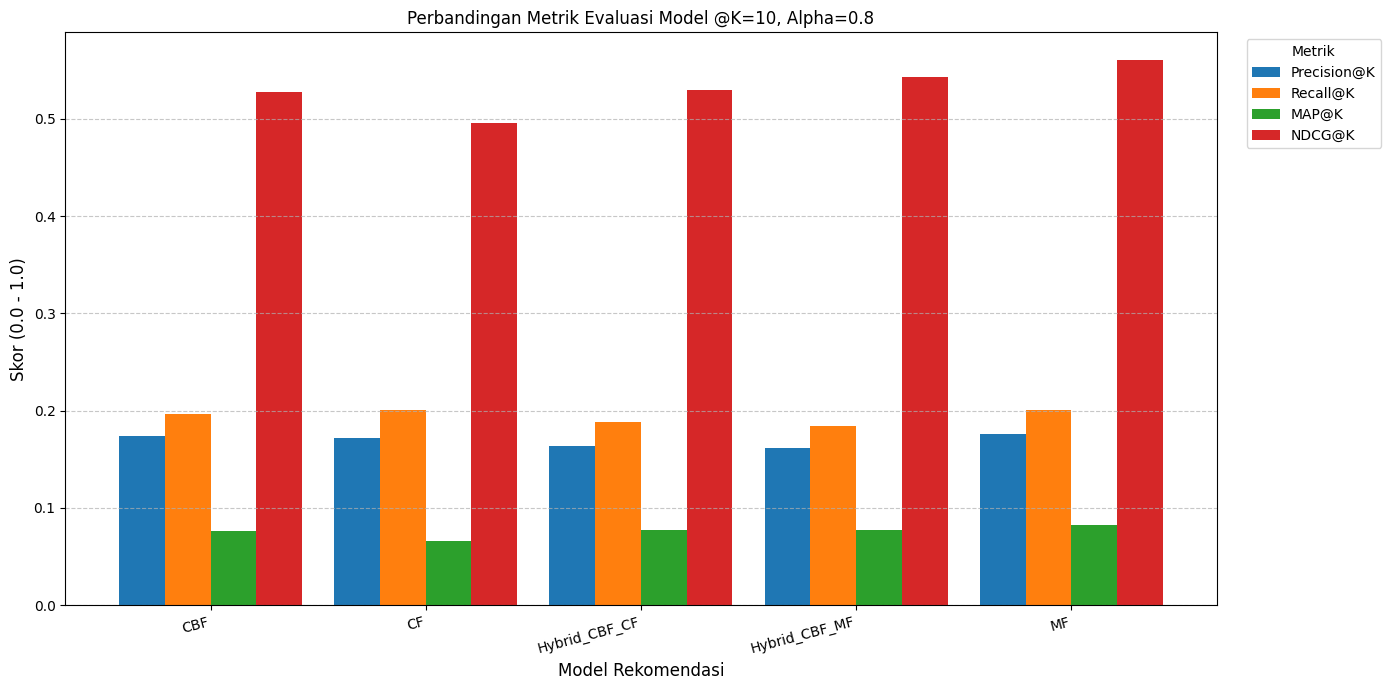

In [ ]:
# ----------------------------------------------------------------------------
## 9. EVALUASI SEMUA MODEL (Diperbarui)
# ----------------------------------------------------------------------------

def calculate_all_metrics(recommendations, recommendation_scores, relevant_items_binary, relevant_items_scores_dict):
    """
    Menghitung Precision, Recall, AP@K, dan NDCG@K.
    
    Args:
        recommendations (list): Daftar 'title' yang direkomendasikan.
        recommendation_scores (list): Daftar SKOR PREDIKSI dari model untuk 'title' tsb.
        relevant_items_binary (set): Set 'title' yang relevan (rating >= 4) di data uji.
        relevant_items_scores_dict (dict): Dict {'title': rating} dari SEMUA item di data uji.
    """
    K = len(recommendations)
    if K == 0:
        return 0.0, 0.0, 0.0, 0.0

    # --- Precision dan Recall ---
    relevant_and_recommended = set(recommendations) & relevant_items_binary
    
    precision = len(relevant_and_recommended) / K
    
    total_relevant_binary = len(relevant_items_binary)
    recall = 0.0
    if total_relevant_binary > 0:
        recall = len(relevant_and_recommended) / total_relevant_binary
        
    # --- Average Precision (AP@K) ---
    ap = 0.0
    hits = 0
    if total_relevant_binary > 0:
        for i, title in enumerate(recommendations, 1):
            if title in relevant_items_binary:
                hits += 1
                precision_at_k = hits / i
                ap += precision_at_k
        ap /= total_relevant_binary
        
    # --- Normalized Discounted Cumulative Gain (NDCG@K) ---
    y_true_relevance = [relevant_items_scores_dict.get(title, 0) for title in recommendations]
    y_scores_list = list(recommendation_scores)
    
    ndcg = 0.0
    if np.sum(y_true_relevance) > 0:
        ndcg = ndcg_score([y_true_relevance], [y_scores_list], k=K)
        
    return precision, recall, ap, ndcg

# --- Persiapan Ground Truth dari Data Uji ---
RELEVANCE_THRESHOLD = 4

test_ground_truth_binary = df_test[df_test['rating'] >= RELEVANCE_THRESHOLD]\
                                .groupby('user_name')['title']\
                                .apply(set).to_dict()

test_ground_truth_scores = df_test.groupby('user_name')\
                                .apply(lambda x: pd.Series(x.rating.values, index=x.title).to_dict())\
                                .to_dict()


# --- Jalankan Evaluasi ---
K_EVAL = 10 # Kita evaluasi di Top-5
ALPHA_HYBRID = 0.8 # Bobot untuk model hybrid (0.5 = 50% CBF, 50% CF/MF)

results = []

# Loop hanya pada pengguna yang ada di data latih
for user_name in users:
    
    # Ambil item relevan untuk user ini dari data UJI
    relevant_items_binary = test_ground_truth_binary.get(user_name, set())
    relevant_items_scores = test_ground_truth_scores.get(user_name, {})
    
    # Hanya evaluasi jika ada item relevan (biner) di test set
    if not relevant_items_binary:
        continue

    # 1. Evaluasi CBF
    rec_cbf, scores_cbf = recommend_cbf(user_name, top_k=K_EVAL)
    p_cbf, r_cbf, ap_cbf, ndcg_cbf = calculate_all_metrics(rec_cbf, scores_cbf, relevant_items_binary, relevant_items_scores)
    results.append({'user': user_name, 'model': 'CBF', 'Precision@K': p_cbf, 'Recall@K': r_cbf, 'AP@K': ap_cbf, 'NDCG@K': ndcg_cbf})

    # 2. Evaluasi CF
    rec_cf, scores_cf = recommend_cf(user_name, top_k=K_EVAL)
    p_cf, r_cf, ap_cf, ndcg_cf = calculate_all_metrics(rec_cf, scores_cf, relevant_items_binary, relevant_items_scores)
    results.append({'user': user_name, 'model': 'CF', 'Precision@K': p_cf, 'Recall@K': r_cf, 'AP@K': ap_cf, 'NDCG@K': ndcg_cf})

    # 3. Evaluasi MF
    rec_mf, scores_mf = recommend_mf(user_name, top_k=K_EVAL)
    p_mf, r_mf, ap_mf, ndcg_mf = calculate_all_metrics(rec_mf, scores_mf, relevant_items_binary, relevant_items_scores)
    results.append({'user': user_name, 'model': 'MF', 'Precision@K': p_mf, 'Recall@K': r_mf, 'AP@K': ap_mf, 'NDCG@K': ndcg_mf})

    # 4. Evaluasi Hybrid CBF + CF
    rec_hyb_cf, scores_hyb_cf = recommend_hybrid_cbf_cf(user_name, top_k=K_EVAL, alpha=ALPHA_HYBRID)
    p_hyb_cf, r_hyb_cf, ap_hyb_cf, ndcg_hyb_cf = calculate_all_metrics(rec_hyb_cf, scores_hyb_cf, relevant_items_binary, relevant_items_scores)
    results.append({'user': user_name, 'model': 'Hybrid_CBF_CF', 'Precision@K': p_hyb_cf, 'Recall@K': r_hyb_cf, 'AP@K': ap_hyb_cf, 'NDCG@K': ndcg_hyb_cf})
    
    # 5. Evaluasi Hybrid CBF + MF
    rec_hyb_mf, scores_hyb_mf = recommend_hybrid_cbf_mf(user_name, top_k=K_EVAL, alpha=ALPHA_HYBRID)
    p_hyb_mf, r_hyb_mf, ap_hyb_mf, ndcg_hyb_mf = calculate_all_metrics(rec_hyb_mf, scores_hyb_mf, relevant_items_binary, relevant_items_scores)
    results.append({'user': user_name, 'model': 'Hybrid_CBF_MF', 'Precision@K': p_hyb_mf, 'Recall@K': r_hyb_mf, 'AP@K': ap_hyb_mf, 'NDCG@K': ndcg_hyb_mf})


# --- Tampilkan Hasil Rata-rata ---
if results:
    df_results = pd.DataFrame(results)
    
    print(f"--- Hasil Evaluasi Rata-rata @K={K_EVAL}, Alpha={ALPHA_HYBRID} (pada Data Uji) ---")
    
    metric_results = df_results.groupby('model')[['Precision@K', 'Recall@K', 'AP@K', 'NDCG@K']].mean()
    metric_results.rename(columns={'AP@K': 'MAP@K'}, inplace=True)
    
    # Urutkan berdasarkan NDCG untuk melihat model terbaik
    print(metric_results.sort_values(by='NDCG@K', ascending=False))
    try:
        # Impor library plotting
        import matplotlib.pyplot as plt
        
        # Membuat bar chart dari metric_results
        # 'ax' adalah objek plot (axes)
        ax = metric_results.plot(
            kind='bar', 
            figsize=(14, 7), # Ukuran gambar (lebar, tinggi)
            title=f'Perbandingan Metrik Evaluasi Model @K={K_EVAL}, Alpha={ALPHA_HYBRID}',
            width=0.85 # Lebar grup bar
        )
        
        # Pengaturan label
        ax.set_xlabel("Model Rekomendasi", fontsize=12)
        ax.set_ylabel("Skor (0.0 - 1.0)", fontsize=12)
        
        # Memindahkan legenda ke luar plot agar tidak menutupi
        ax.legend(title="Metrik", bbox_to_anchor=(1.02, 1), loc='upper left')
        
        # Menambahkan grid di sumbu Y untuk kemudahan membaca
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Rotasi label x-axis (nama model) agar tidak tumpang tindih
        plt.xticks(rotation=15, ha='right')
        
        # Menyesuaikan layout agar pas
        plt.tight_layout()
        
        # Menampilkan plot
        plt.show()

        # 

    except ImportError:
        print("\n--- Gagal membuat grafik ---")
        print("Silakan install 'matplotlib' untuk menampilkan grafik evaluasi:")
        print("pip install matplotlib")
    
else:
    print("Tidak ada data uji yang relevan untuk dievaluasi (data mockup terlalu kecil).")

--- Hasil Evaluasi Rata-rata @K=20, Alpha=0.8 (pada Data Uji) ---
               Precision@K  Recall@K     MAP@K    NDCG@K
model                                                   
MF                   0.179  0.410706  0.129400  0.553933
Hybrid_CBF_MF        0.175  0.401341  0.123252  0.542572
CBF                  0.161  0.370592  0.111416  0.533938
Hybrid_CBF_CF        0.168  0.385197  0.117172  0.522148
CF                   0.163  0.374293  0.103652  0.503447


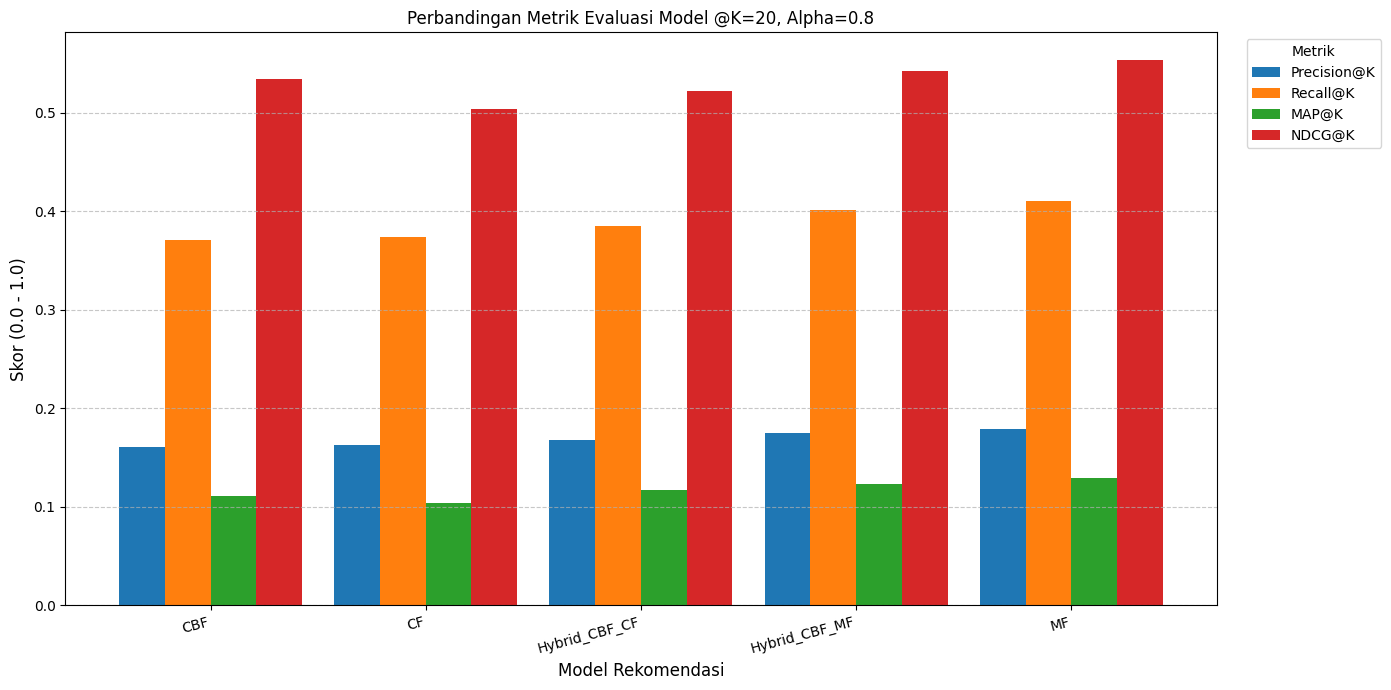

In [85]:
# --- Jalankan Evaluasi ---
K_EVAL = 20 # Kita evaluasi di Top-20
ALPHA_HYBRID = 0.8 # Bobot untuk model hybrid (0.5 = 50% CBF, 50% CF/MF)

results = []

# Loop hanya pada pengguna yang ada di data latih
for user_name in users:
    
    # Ambil item relevan untuk user ini dari data UJI
    relevant_items_binary = test_ground_truth_binary.get(user_name, set())
    relevant_items_scores = test_ground_truth_scores.get(user_name, {})
    
    # Hanya evaluasi jika ada item relevan (biner) di test set
    if not relevant_items_binary:
        continue

    # 1. Evaluasi CBF
    rec_cbf, scores_cbf = recommend_cbf(user_name, top_k=K_EVAL)
    p_cbf, r_cbf, ap_cbf, ndcg_cbf = calculate_all_metrics(rec_cbf, scores_cbf, relevant_items_binary, relevant_items_scores)
    results.append({'user': user_name, 'model': 'CBF', 'Precision@K': p_cbf, 'Recall@K': r_cbf, 'AP@K': ap_cbf, 'NDCG@K': ndcg_cbf})

    # 2. Evaluasi CF
    rec_cf, scores_cf = recommend_cf(user_name, top_k=K_EVAL)
    p_cf, r_cf, ap_cf, ndcg_cf = calculate_all_metrics(rec_cf, scores_cf, relevant_items_binary, relevant_items_scores)
    results.append({'user': user_name, 'model': 'CF', 'Precision@K': p_cf, 'Recall@K': r_cf, 'AP@K': ap_cf, 'NDCG@K': ndcg_cf})

    # 3. Evaluasi MF
    rec_mf, scores_mf = recommend_mf(user_name, top_k=K_EVAL)
    p_mf, r_mf, ap_mf, ndcg_mf = calculate_all_metrics(rec_mf, scores_mf, relevant_items_binary, relevant_items_scores)
    results.append({'user': user_name, 'model': 'MF', 'Precision@K': p_mf, 'Recall@K': r_mf, 'AP@K': ap_mf, 'NDCG@K': ndcg_mf})

    # 4. Evaluasi Hybrid CBF + CF
    rec_hyb_cf, scores_hyb_cf = recommend_hybrid_cbf_cf(user_name, top_k=K_EVAL, alpha=ALPHA_HYBRID)
    p_hyb_cf, r_hyb_cf, ap_hyb_cf, ndcg_hyb_cf = calculate_all_metrics(rec_hyb_cf, scores_hyb_cf, relevant_items_binary, relevant_items_scores)
    results.append({'user': user_name, 'model': 'Hybrid_CBF_CF', 'Precision@K': p_hyb_cf, 'Recall@K': r_hyb_cf, 'AP@K': ap_hyb_cf, 'NDCG@K': ndcg_hyb_cf})
    
    # 5. Evaluasi Hybrid CBF + MF
    rec_hyb_mf, scores_hyb_mf = recommend_hybrid_cbf_mf(user_name, top_k=K_EVAL, alpha=ALPHA_HYBRID)
    p_hyb_mf, r_hyb_mf, ap_hyb_mf, ndcg_hyb_mf = calculate_all_metrics(rec_hyb_mf, scores_hyb_mf, relevant_items_binary, relevant_items_scores)
    results.append({'user': user_name, 'model': 'Hybrid_CBF_MF', 'Precision@K': p_hyb_mf, 'Recall@K': r_hyb_mf, 'AP@K': ap_hyb_mf, 'NDCG@K': ndcg_hyb_mf})


# --- Tampilkan Hasil Rata-rata ---
if results:
    df_results = pd.DataFrame(results)
    
    print(f"--- Hasil Evaluasi Rata-rata @K={K_EVAL}, Alpha={ALPHA_HYBRID} (pada Data Uji) ---")
    
    metric_results = df_results.groupby('model')[['Precision@K', 'Recall@K', 'AP@K', 'NDCG@K']].mean()
    metric_results.rename(columns={'AP@K': 'MAP@K'}, inplace=True)
    
    # Urutkan berdasarkan NDCG untuk melihat model terbaik
    print(metric_results.sort_values(by='NDCG@K', ascending=False))
    try:
        # Impor library plotting
        import matplotlib.pyplot as plt
        
        # Membuat bar chart dari metric_results
        # 'ax' adalah objek plot (axes)
        ax = metric_results.plot(
            kind='bar', 
            figsize=(14, 7), # Ukuran gambar (lebar, tinggi)
            title=f'Perbandingan Metrik Evaluasi Model @K={K_EVAL}, Alpha={ALPHA_HYBRID}',
            width=0.85 # Lebar grup bar
        )
        
        # Pengaturan label
        ax.set_xlabel("Model Rekomendasi", fontsize=12)
        ax.set_ylabel("Skor (0.0 - 1.0)", fontsize=12)
        
        # Memindahkan legenda ke luar plot agar tidak menutupi
        ax.legend(title="Metrik", bbox_to_anchor=(1.02, 1), loc='upper left')
        
        # Menambahkan grid di sumbu Y untuk kemudahan membaca
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Rotasi label x-axis (nama model) agar tidak tumpang tindih
        plt.xticks(rotation=15, ha='right')
        
        # Menyesuaikan layout agar pas
        plt.tight_layout()
        
        # Menampilkan plot
        plt.show()

        # 

    except ImportError:
        print("\n--- Gagal membuat grafik ---")
        print("Silakan install 'matplotlib' untuk menampilkan grafik evaluasi:")
        print("pip install matplotlib")
    
else:
    print("Tidak ada data uji yang relevan untuk dievaluasi (data mockup terlalu kecil).")

--- Hasil Evaluasi Rata-rata @K=10, Alpha=0.5 (pada Data Uji) ---
               Precision@K  Recall@K     MAP@K    NDCG@K
model                                                   
MF                   0.176  0.200942  0.082967  0.560814
Hybrid_CBF_MF        0.180  0.206657  0.086379  0.550040
CBF                  0.174  0.196439  0.076616  0.527066
Hybrid_CBF_CF        0.172  0.196119  0.076545  0.512955
CF                   0.172  0.200333  0.065667  0.495414


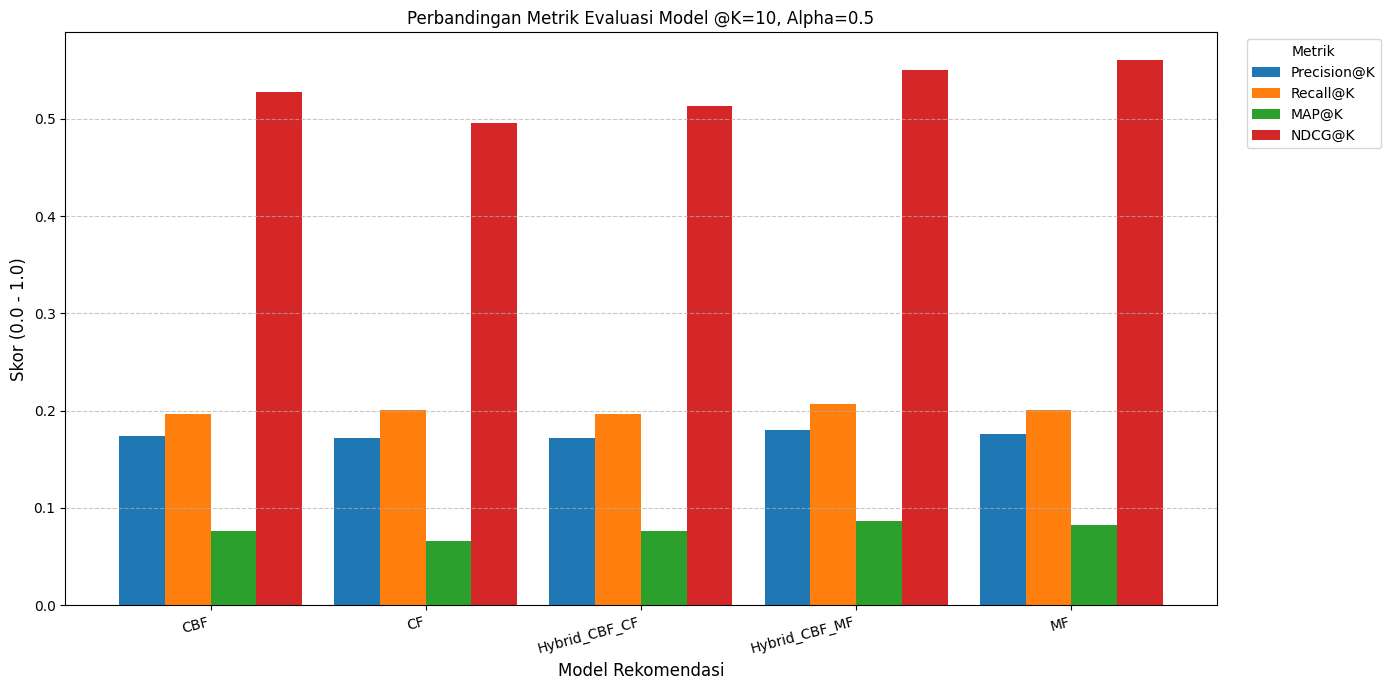

In [87]:
# --- Jalankan Evaluasi ---
K_EVAL = 10 # Kita evaluasi di Top-5
ALPHA_HYBRID = 0.5 # Bobot untuk model hybrid (0.5 = 50% CBF, 50% CF/MF)

results = []

# Loop hanya pada pengguna yang ada di data latih
for user_name in users:
    
    # Ambil item relevan untuk user ini dari data UJI
    relevant_items_binary = test_ground_truth_binary.get(user_name, set())
    relevant_items_scores = test_ground_truth_scores.get(user_name, {})
    
    # Hanya evaluasi jika ada item relevan (biner) di test set
    if not relevant_items_binary:
        continue

    # 1. Evaluasi CBF
    rec_cbf, scores_cbf = recommend_cbf(user_name, top_k=K_EVAL)
    p_cbf, r_cbf, ap_cbf, ndcg_cbf = calculate_all_metrics(rec_cbf, scores_cbf, relevant_items_binary, relevant_items_scores)
    results.append({'user': user_name, 'model': 'CBF', 'Precision@K': p_cbf, 'Recall@K': r_cbf, 'AP@K': ap_cbf, 'NDCG@K': ndcg_cbf})

    # 2. Evaluasi CF
    rec_cf, scores_cf = recommend_cf(user_name, top_k=K_EVAL)
    p_cf, r_cf, ap_cf, ndcg_cf = calculate_all_metrics(rec_cf, scores_cf, relevant_items_binary, relevant_items_scores)
    results.append({'user': user_name, 'model': 'CF', 'Precision@K': p_cf, 'Recall@K': r_cf, 'AP@K': ap_cf, 'NDCG@K': ndcg_cf})

    # 3. Evaluasi MF
    rec_mf, scores_mf = recommend_mf(user_name, top_k=K_EVAL)
    p_mf, r_mf, ap_mf, ndcg_mf = calculate_all_metrics(rec_mf, scores_mf, relevant_items_binary, relevant_items_scores)
    results.append({'user': user_name, 'model': 'MF', 'Precision@K': p_mf, 'Recall@K': r_mf, 'AP@K': ap_mf, 'NDCG@K': ndcg_mf})

    # 4. Evaluasi Hybrid CBF + CF
    rec_hyb_cf, scores_hyb_cf = recommend_hybrid_cbf_cf(user_name, top_k=K_EVAL, alpha=ALPHA_HYBRID)
    p_hyb_cf, r_hyb_cf, ap_hyb_cf, ndcg_hyb_cf = calculate_all_metrics(rec_hyb_cf, scores_hyb_cf, relevant_items_binary, relevant_items_scores)
    results.append({'user': user_name, 'model': 'Hybrid_CBF_CF', 'Precision@K': p_hyb_cf, 'Recall@K': r_hyb_cf, 'AP@K': ap_hyb_cf, 'NDCG@K': ndcg_hyb_cf})
    
    # 5. Evaluasi Hybrid CBF + MF
    rec_hyb_mf, scores_hyb_mf = recommend_hybrid_cbf_mf(user_name, top_k=K_EVAL, alpha=ALPHA_HYBRID)
    p_hyb_mf, r_hyb_mf, ap_hyb_mf, ndcg_hyb_mf = calculate_all_metrics(rec_hyb_mf, scores_hyb_mf, relevant_items_binary, relevant_items_scores)
    results.append({'user': user_name, 'model': 'Hybrid_CBF_MF', 'Precision@K': p_hyb_mf, 'Recall@K': r_hyb_mf, 'AP@K': ap_hyb_mf, 'NDCG@K': ndcg_hyb_mf})


# --- Tampilkan Hasil Rata-rata ---
if results:
    df_results = pd.DataFrame(results)
    
    print(f"--- Hasil Evaluasi Rata-rata @K={K_EVAL}, Alpha={ALPHA_HYBRID} (pada Data Uji) ---")
    
    metric_results = df_results.groupby('model')[['Precision@K', 'Recall@K', 'AP@K', 'NDCG@K']].mean()
    metric_results.rename(columns={'AP@K': 'MAP@K'}, inplace=True)
    
    # Urutkan berdasarkan NDCG untuk melihat model terbaik
    print(metric_results.sort_values(by='NDCG@K', ascending=False))
    try:
        # Impor library plotting
        import matplotlib.pyplot as plt
        
        # Membuat bar chart dari metric_results
        # 'ax' adalah objek plot (axes)
        ax = metric_results.plot(
            kind='bar', 
            figsize=(14, 7), # Ukuran gambar (lebar, tinggi)
            title=f'Perbandingan Metrik Evaluasi Model @K={K_EVAL}, Alpha={ALPHA_HYBRID}',
            width=0.85 # Lebar grup bar
        )
        
        # Pengaturan label
        ax.set_xlabel("Model Rekomendasi", fontsize=12)
        ax.set_ylabel("Skor (0.0 - 1.0)", fontsize=12)
        
        # Memindahkan legenda ke luar plot agar tidak menutupi
        ax.legend(title="Metrik", bbox_to_anchor=(1.02, 1), loc='upper left')
        
        # Menambahkan grid di sumbu Y untuk kemudahan membaca
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Rotasi label x-axis (nama model) agar tidak tumpang tindih
        plt.xticks(rotation=15, ha='right')
        
        # Menyesuaikan layout agar pas
        plt.tight_layout()
        
        # Menampilkan plot
        plt.show()

        # 

    except ImportError:
        print("\n--- Gagal membuat grafik ---")
        print("Silakan install 'matplotlib' untuk menampilkan grafik evaluasi:")
        print("pip install matplotlib")
    
else:
    print("Tidak ada data uji yang relevan untuk dievaluasi (data mockup terlalu kecil).")

--- Hasil Evaluasi Rata-rata @K=20, Alpha=0.5 (pada Data Uji) ---
               Precision@K  Recall@K     MAP@K    NDCG@K
model                                                   
Hybrid_CBF_MF        0.168  0.385504  0.125247  0.554978
MF                   0.179  0.410706  0.129400  0.553933
CBF                  0.161  0.370592  0.111416  0.533938
Hybrid_CBF_CF        0.161  0.372354  0.112236  0.517945
CF                   0.163  0.374293  0.103652  0.503447


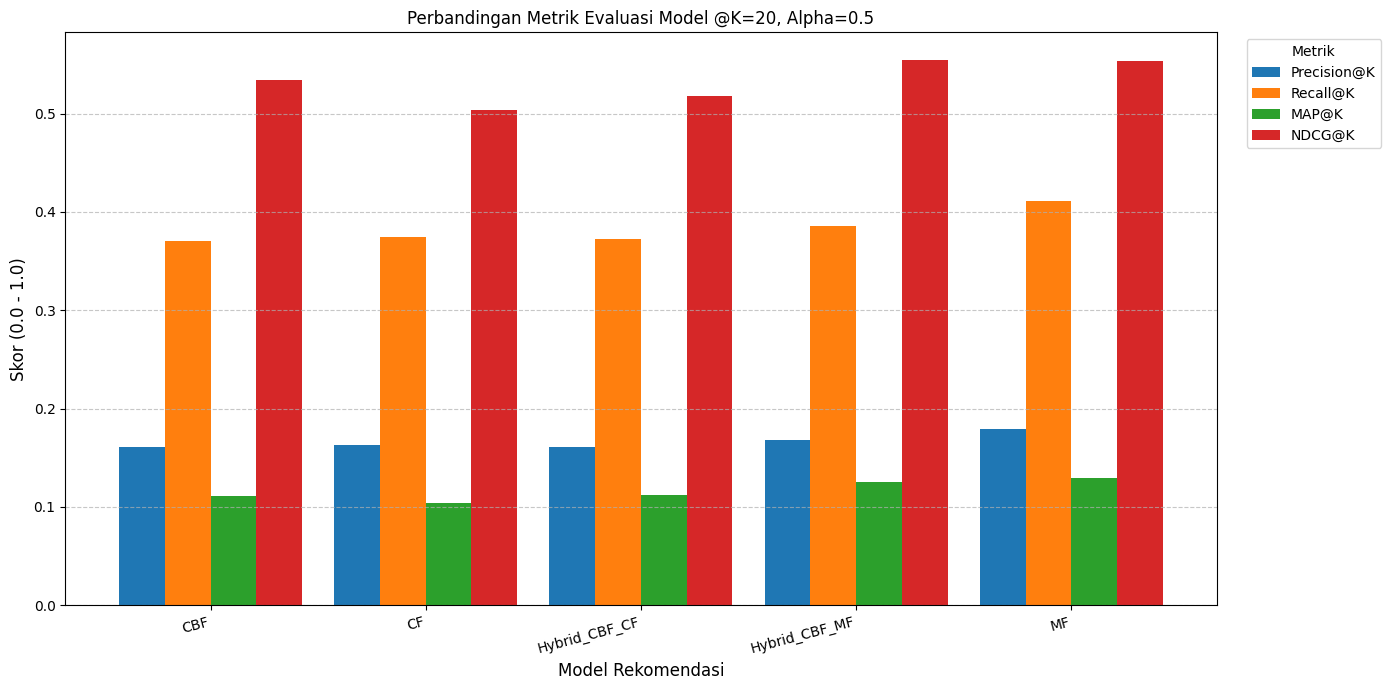

In [89]:
# --- Jalankan Evaluasi ---
K_EVAL = 20 # Kita evaluasi di Top-5
ALPHA_HYBRID = 0.5 # Bobot untuk model hybrid (0.5 = 50% CBF, 50% CF/MF)

results = []

# Loop hanya pada pengguna yang ada di data latih
for user_name in users:
    
    # Ambil item relevan untuk user ini dari data UJI
    relevant_items_binary = test_ground_truth_binary.get(user_name, set())
    relevant_items_scores = test_ground_truth_scores.get(user_name, {})
    
    # Hanya evaluasi jika ada item relevan (biner) di test set
    if not relevant_items_binary:
        continue

    # 1. Evaluasi CBF
    rec_cbf, scores_cbf = recommend_cbf(user_name, top_k=K_EVAL)
    p_cbf, r_cbf, ap_cbf, ndcg_cbf = calculate_all_metrics(rec_cbf, scores_cbf, relevant_items_binary, relevant_items_scores)
    results.append({'user': user_name, 'model': 'CBF', 'Precision@K': p_cbf, 'Recall@K': r_cbf, 'AP@K': ap_cbf, 'NDCG@K': ndcg_cbf})

    # 2. Evaluasi CF
    rec_cf, scores_cf = recommend_cf(user_name, top_k=K_EVAL)
    p_cf, r_cf, ap_cf, ndcg_cf = calculate_all_metrics(rec_cf, scores_cf, relevant_items_binary, relevant_items_scores)
    results.append({'user': user_name, 'model': 'CF', 'Precision@K': p_cf, 'Recall@K': r_cf, 'AP@K': ap_cf, 'NDCG@K': ndcg_cf})

    # 3. Evaluasi MF
    rec_mf, scores_mf = recommend_mf(user_name, top_k=K_EVAL)
    p_mf, r_mf, ap_mf, ndcg_mf = calculate_all_metrics(rec_mf, scores_mf, relevant_items_binary, relevant_items_scores)
    results.append({'user': user_name, 'model': 'MF', 'Precision@K': p_mf, 'Recall@K': r_mf, 'AP@K': ap_mf, 'NDCG@K': ndcg_mf})

    # 4. Evaluasi Hybrid CBF + CF
    rec_hyb_cf, scores_hyb_cf = recommend_hybrid_cbf_cf(user_name, top_k=K_EVAL, alpha=ALPHA_HYBRID)
    p_hyb_cf, r_hyb_cf, ap_hyb_cf, ndcg_hyb_cf = calculate_all_metrics(rec_hyb_cf, scores_hyb_cf, relevant_items_binary, relevant_items_scores)
    results.append({'user': user_name, 'model': 'Hybrid_CBF_CF', 'Precision@K': p_hyb_cf, 'Recall@K': r_hyb_cf, 'AP@K': ap_hyb_cf, 'NDCG@K': ndcg_hyb_cf})
    
    # 5. Evaluasi Hybrid CBF + MF
    rec_hyb_mf, scores_hyb_mf = recommend_hybrid_cbf_mf(user_name, top_k=K_EVAL, alpha=ALPHA_HYBRID)
    p_hyb_mf, r_hyb_mf, ap_hyb_mf, ndcg_hyb_mf = calculate_all_metrics(rec_hyb_mf, scores_hyb_mf, relevant_items_binary, relevant_items_scores)
    results.append({'user': user_name, 'model': 'Hybrid_CBF_MF', 'Precision@K': p_hyb_mf, 'Recall@K': r_hyb_mf, 'AP@K': ap_hyb_mf, 'NDCG@K': ndcg_hyb_mf})


# --- Tampilkan Hasil Rata-rata ---
if results:
    df_results = pd.DataFrame(results)
    
    print(f"--- Hasil Evaluasi Rata-rata @K={K_EVAL}, Alpha={ALPHA_HYBRID} (pada Data Uji) ---")
    
    metric_results = df_results.groupby('model')[['Precision@K', 'Recall@K', 'AP@K', 'NDCG@K']].mean()
    metric_results.rename(columns={'AP@K': 'MAP@K'}, inplace=True)
    
    # Urutkan berdasarkan NDCG untuk melihat model terbaik
    print(metric_results.sort_values(by='NDCG@K', ascending=False))
    try:
        # Impor library plotting
        import matplotlib.pyplot as plt
        
        # Membuat bar chart dari metric_results
        # 'ax' adalah objek plot (axes)
        ax = metric_results.plot(
            kind='bar', 
            figsize=(14, 7), # Ukuran gambar (lebar, tinggi)
            title=f'Perbandingan Metrik Evaluasi Model @K={K_EVAL}, Alpha={ALPHA_HYBRID}',
            width=0.85 # Lebar grup bar
        )
        
        # Pengaturan label
        ax.set_xlabel("Model Rekomendasi", fontsize=12)
        ax.set_ylabel("Skor (0.0 - 1.0)", fontsize=12)
        
        # Memindahkan legenda ke luar plot agar tidak menutupi
        ax.legend(title="Metrik", bbox_to_anchor=(1.02, 1), loc='upper left')
        
        # Menambahkan grid di sumbu Y untuk kemudahan membaca
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Rotasi label x-axis (nama model) agar tidak tumpang tindih
        plt.xticks(rotation=15, ha='right')
        
        # Menyesuaikan layout agar pas
        plt.tight_layout()
        
        # Menampilkan plot
        plt.show()

        # 

    except ImportError:
        print("\n--- Gagal membuat grafik ---")
        print("Silakan install 'matplotlib' untuk menampilkan grafik evaluasi:")
        print("pip install matplotlib")
    
else:
    print("Tidak ada data uji yang relevan untuk dievaluasi (data mockup terlalu kecil).")